# Trajectory Recommendation

<a id='toc'></a>

# 1. Preprocess Dataset

In [1]:
% matplotlib inline

import os, sys, time, pickle, tempfile
import math, random, itertools
import pandas as pd
import numpy as np
import heapq as hq
from scipy.linalg import kron
from scipy.optimize import minimize
from scipy.stats import kendalltau

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans

from pystruct.models import StructuredModel
from pystruct.learners import OneSlackSSVM

from joblib import Parallel, delayed
import cython
import pulp

In [2]:
random.seed(1234567890)
np.random.seed(1234567890)
LOG_SMALL = -10
LOG_ZERO = -1000
ranksvm_dir = '$HOME/work/ranksvm'  # directory that contains rankSVM binaries: train, predict, svm-scale

In [3]:
data_dir = 'data/data-new'
dat_suffix = ['Osak', 'Glas', 'Edin', 'Toro', 'Melb']

In [4]:
dat_ix = 0

Hyperparameters.

In [5]:
ALPHA_SET = [0.1, 0.3, 0.5, 0.7, 0.9]  # trade-off parameters

In [6]:
BIN_CLUSTER = 5  # discritization parameter

In [7]:
RANKSVM_C = 10     # RankSVM regularisation constant
LOGIT_C = 1        # Logistic regression regularisation constant, smaller values specify stronger regularisation
SSVM_C = 1         # Structured SVM regularisation constant
N_JOBS = 8         # number of parallel jobs
USE_GUROBI = False # whether to use GUROBI as ILP solver
DO_NORM = True     # whether normalise features

Method switches.

In [8]:
run_ssvm = True
run_logreg = False
run_linreg = False
run_logpwr = False
run_rank = False
run_tran = False
run_comb = False
run_rand = False

Generate results filenames.

In [9]:
def gen_fname(dat_ix):
    assert(0 <= dat_ix < len(dat_suffix))
    
    suffix = dat_suffix[dat_ix] + '.pkl'
    
    fssvm = os.path.join(data_dir, 'ssvm-' + suffix)
    flogreg = os.path.join(data_dir, 'logreg-' + suffix)
    flinreg = os.path.join(data_dir, 'linreg-' + suffix)
    logpwr = os.path.join(data_dir, 'logpwr-' + suffix)
    frank = os.path.join(data_dir, 'rank-' + suffix)
    ftran = os.path.join(data_dir, 'tran-' + suffix)
    fcomb = os.path.join(data_dir, 'comb-' + suffix)
    frand = os.path.join(data_dir, 'rand-' + suffix)
    return fssvm, flogreg, flinreg, logpwr, frank, ftran, fcomb, frand

In [10]:
frecdict_ssvm, frecdict_logreg, frecdict_linreg, frecdict_logpwr, \
frecdict_rank, frecdict_tran, frecdict_comb, frecdict_rand = gen_fname(dat_ix)
print(frecdict_ssvm)
print(frecdict_logreg)
print(frecdict_linreg)
print(frecdict_logpwr)
print(frecdict_rank)
print(frecdict_tran)
print(frecdict_comb)
print(frecdict_rand)

data/data-new/ssvm-Osak.pkl
data/data-new/logreg-Osak.pkl
data/data-new/linreg-Osak.pkl
data/data-new/logpwr-Osak.pkl
data/data-new/rank-Osak.pkl
data/data-new/tran-Osak.pkl
data/data-new/comb-Osak.pkl
data/data-new/rand-Osak.pkl


## 1.1 Load Data

In [11]:
fpoi = os.path.join(data_dir, 'poi-' + dat_suffix[dat_ix] + '.csv')

In [12]:
poi_all = pd.read_csv(fpoi)
poi_all.set_index('poiID', inplace=True)
poi_all.head()

,poiCat,poiLon,poiLat
poiID,,,
1,Amusement,135.428938,34.654792
2,Amusement,135.430627,34.656145
3,Amusement,135.508558,34.652423
4,Amusement,135.433627,34.664758
5,Amusement,135.499894,34.703680


In [13]:
ftraj = os.path.join(data_dir, 'traj-' + dat_suffix[dat_ix] + '.csv')

In [14]:
traj_all = pd.read_csv(ftraj)
traj_all.head()

,userID,trajID,poiID,startTime,endTime,#photo,trajLen,poiDuration
0,10297518@N00,1,20,1277719324,1277720832,6,1,1508
1,10307040@N08,2,6,1382608644,1382608644,1,4,0
2,10307040@N08,2,8,1382607812,1382607812,1,4,0
3,10307040@N08,2,21,1382607761,1382607774,2,4,13
4,10307040@N08,2,22,1382607879,1382608628,9,4,749


In [15]:
num_user = traj_all['userID'].unique().shape[0]
num_poi = traj_all['poiID'].unique().shape[0]
num_traj = traj_all['trajID'].unique().shape[0]
pd.DataFrame({'#user': num_user, '#poi': num_poi, '#traj': num_traj, '#traj/user': num_traj/num_user}, \
             index=[str(dat_suffix[dat_ix])])

,#poi,#traj,#traj/user,#user
Osak,27,1115,2.477778,450


Distribution of the number of POIs in trajectories.

In [16]:
#ax = traj_all['trajLen'].hist(bins=20)
#ax.set_yscale('log')
#ax.set_xlabel('#POIs in trajectory'); ax.set_ylabel('#Trajectories')

Distribution of POI visit duration.

In [17]:
#ax = traj_all['poiDuration'].hist(bins=20)
#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_xlabel('POI visit duration (sec)'); ax.set_ylabel('#POI visits')

## 1.2 Utility Functions

Print computing progress.

In [18]:
def print_progress(cnt, total):
    """Display a progress bar"""
    assert(cnt > 0 and total > 0 and cnt <= total)
    length = 80
    ratio = cnt / total
    n = int(length * ratio)
    sys.stdout.write('\r[%-80s] %d%%' % ('-'*n, int(ratio*100)))
    sys.stdout.flush()

Extract trajectory, i.e., a list of POIs.

In [19]:
def extract_traj(tid, traj_all):
    traj = traj_all[traj_all['trajID'] == tid].copy()
    traj.sort_values(by=['startTime'], ascending=True, inplace=True)
    return traj['poiID'].tolist()

Compute POI properties, e.g., popularity, total number of visit, average visit duration.

In [20]:
def calc_poi_info(trajid_list, traj_all, poi_all):
    assert(len(trajid_list) > 0)
    poi_info = traj_all[traj_all['trajID'] == trajid_list[0]][['poiID', 'poiDuration']].copy() 
    for i in range(1, len(trajid_list)):
        traj = traj_all[traj_all['trajID'] == trajid_list[i]][['poiID', 'poiDuration']]
        poi_info = poi_info.append(traj, ignore_index=True)
    
    poi_info = poi_info.groupby('poiID').agg([np.mean, np.size])
    poi_info.columns = poi_info.columns.droplevel()
    poi_info.reset_index(inplace=True)
    poi_info.rename(columns={'mean':'avgDuration', 'size':'nVisit'}, inplace=True)
    poi_info.set_index('poiID', inplace=True) 
    poi_info['poiCat'] = poi_all.loc[poi_info.index, 'poiCat']
    poi_info['poiLon'] = poi_all.loc[poi_info.index, 'poiLon']
    poi_info['poiLat'] = poi_all.loc[poi_info.index, 'poiLat']
    
    # POI popularity: the number of distinct users that visited the POI
    pop_df = traj_all[traj_all['trajID'].isin(trajid_list)][['poiID', 'userID']].copy()
    pop_df = pop_df.groupby('poiID').agg(pd.Series.nunique)
    pop_df.rename(columns={'userID':'nunique'}, inplace=True)
    poi_info['popularity'] = pop_df.loc[poi_info.index, 'nunique']
    
    return poi_info.copy()

Compute the F1 score for recommended trajectory.

In [21]:
def calc_F1(traj_act, traj_rec, noloop=False):
    '''Compute recall, precision and F1 for recommended trajectories'''
    assert(isinstance(noloop, bool))
    assert(len(traj_act) > 0)
    assert(len(traj_rec) > 0)
    
    if noloop == True:
        intersize = len(set(traj_act) & set(traj_rec))
    else:
        match_tags = np.zeros(len(traj_act), dtype=np.bool)
        for poi in traj_rec:
            for j in range(len(traj_act)):
                if match_tags[j] == False and poi == traj_act[j]:
                    match_tags[j] = True
                    break
        intersize = np.nonzero(match_tags)[0].shape[0]
        
    recall = intersize / len(traj_act)
    precision = intersize / len(traj_rec)
    F1 = 2 * precision * recall / (precision + recall)
    return F1

Compute the pairs-F1 score for recommended trajectory.

In [22]:
%load_ext Cython

/home/dawei/apps/miniconda3/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "


In [23]:
%%cython
import numpy as np
cimport numpy as np

cpdef float calc_pairsF1(y, y_hat):
    assert(len(y) > 0)
    assert(len(y) == len(set(y))) # no loops in y
    cdef int n, nr, n0, n0r, nc, poi1, poi2, i, j
    n = len(y)
    nr = len(y_hat)
    n0 = int(n*(n-1) / 2)
    n0r = int(nr*(nr-1) / 2)
    
    # y determines the correct visiting order
    order_dict = dict()
    for i in range(n):
        order_dict[y[i]] = i
        
    nc = 0
    for i in range(nr):
        poi1 = y_hat[i]
        for j in range(i+1, nr):
            poi2 = y_hat[j]
            if poi1 in order_dict and poi2 in order_dict and poi1 != poi2:
                if order_dict[poi1] < order_dict[poi2]: nc += 1

    cdef float precision, recall, F1
    precision = (1.0 * nc) / (1.0 * n0r)
    recall = (1.0 * nc) / (1.0 * n0)
    if nc == 0:
        F1 = 0
    else:
        F1 = 2. * precision * recall / (precision + recall)
    return F1

Compute distance between two POIs using [Haversine formula](http://en.wikipedia.org/wiki/Great-circle_distance).

In [24]:
def calc_dist_vec(longitudes1, latitudes1, longitudes2, latitudes2):
    """Calculate the distance (unit: km) between two places on earth, vectorised"""
    # convert degrees to radians
    lng1 = np.radians(longitudes1)
    lat1 = np.radians(latitudes1)
    lng2 = np.radians(longitudes2)
    lat2 = np.radians(latitudes2)
    radius = 6371.0088 # mean earth radius, en.wikipedia.org/wiki/Earth_radius#Mean_radius

    # The haversine formula, en.wikipedia.org/wiki/Great-circle_distance
    dlng = np.fabs(lng1 - lng2)
    dlat = np.fabs(lat1 - lat2)
    dist =  2 * radius * np.arcsin( np.sqrt( 
                (np.sin(0.5*dlat))**2 + np.cos(lat1) * np.cos(lat2) * (np.sin(0.5*dlng))**2 ))
    return dist

Distance between POIs.

In [25]:
POI_DISTMAT = pd.DataFrame(data=np.zeros((poi_all.shape[0], poi_all.shape[0]), dtype=np.float), \
                           index=poi_all.index, columns=poi_all.index)

In [26]:
for ix in poi_all.index:
    POI_DISTMAT.loc[ix] = calc_dist_vec(poi_all.loc[ix, 'poiLon'], \
                                        poi_all.loc[ix, 'poiLat'], \
                                        poi_all['poiLon'], \
                                        poi_all['poiLat'])

In [27]:
trajid_set_all = sorted(traj_all['trajID'].unique().tolist())

In [28]:
poi_info_all = calc_poi_info(trajid_set_all, traj_all, poi_all)

Dictionary maps every trajectory ID to the actual trajectory.

In [29]:
traj_dict = dict()

In [30]:
for trajid in trajid_set_all:
    traj = extract_traj(trajid, traj_all)
    assert(trajid not in traj_dict)
    traj_dict[trajid] = traj

Define a *query* (in IR terminology) using tuple (start POI, end POI, #POI) ~~user ID.~~

In [31]:
QUERY_ID_DICT = dict()  # (start, length) --> qid

In [32]:
keys = [(traj_dict[x][0], len(traj_dict[x])) \
        for x in sorted(traj_dict.keys()) if len(traj_dict[x]) > 1]
cnt = 0
for key in keys:
    if key not in QUERY_ID_DICT:   # (start, length) --> qid
        QUERY_ID_DICT[key] = cnt
        cnt += 1

In [33]:
print('#traj in total:', len(trajid_set_all))
print('#traj (length >= 2):', traj_all[traj_all['trajLen'] >= 2]['trajID'].unique().shape[0])
print('#query tuple:', len(QUERY_ID_DICT))

#traj in total: 1115
#traj (length >= 2): 186
#query tuple: 47


Number of trajectories for each query.

In [34]:
TRAJ_GROUP_DICT = dict()

In [35]:
for tid in traj_dict:
    if len(traj_dict[tid]) > 1:
        key = (traj_dict[tid][0], len(traj_dict[tid]))
        if key in TRAJ_GROUP_DICT: TRAJ_GROUP_DICT[key].add(tid)
        else:                      TRAJ_GROUP_DICT[key] = set({tid})

In [36]:
x = [key for key in sorted(TRAJ_GROUP_DICT.keys())]
y = [len(TRAJ_GROUP_DICT[key]) for key in x]

In [37]:
ix1 = np.argmin(y)
ix2 = np.argmax(y)
print('min:', x[ix1], y[ix1])
print('max:', x[ix2], y[ix2])

min: (2, 5) 1
max: (8, 2) 23


(-1, 25.0)

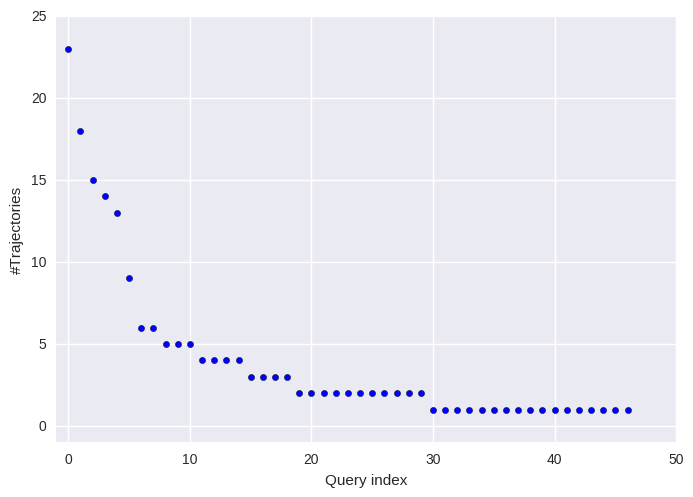

In [38]:
plt.scatter(list(range(len(x))), sorted(y, reverse=True))
plt.ylabel('#Trajectories')
plt.xlabel('Query index')
plt.xlim(xmin=-1)
plt.ylim(ymin=-1)

# 2. POI Ranking

## 2.1 POI Features for Ranking

POI Features used for ranking, given query (`startPOI`, `endPOI`, `nPOI`):
1. `category`: one-hot encoding of POI category, encode `True` as `1` and `False` as `-1`
1. `neighbourhood`: one-hot encoding of POI cluster, encode `True` as `1` and `False` as `-1`
1. `popularity`: log of POI popularity, i.e., the number of distinct users that visited the POI
1. `nVisit`: log of the total number of visit by all users
1. `avgDuration`: log of average POI visit duration
1. `trajLen`: trajectory length, i.e., the number of POIs `nPOI` in trajectory, copy from query
1. `sameCatStart`: 1 if POI category is the same as that of `startPOI`, -1 otherwise
1. `sameCatEnd`: 1 if POI category is the same as that of `endPOI`, -1 otherwise
1. `distStart`: distance (haversine formula) from `startPOI`
1. `distEnd`: distance from `endPOI`
1. `diffPopStart`: difference in POI popularity from `startPOI` (NO LOG as it could be negative)
1. `diffPopEnd`: difference in POI popularity from `endPOI`
1. `diffNVisitStart`: difference in the total number of visit from `startPOI`
1. `diffNVisitEnd`: difference in the total number of visit from `endPOI`
1. `diffDurationStart`: difference in average POI visit duration from the actual duration spent at `startPOI`
1. `diffDurationEnd`: difference in average POI visit duration from the actual duration spent at `endPOI`
1. `sameNeighbourhoodStart`: 1 if POI resides in the same cluster as that of `startPOI`, -1 otherwise
1. `sameNeighbourhoodEnd`: 1 if POI resides in the same cluster as that of `endPOI`, -1 otherwise

In [39]:
DF_COLUMNS = ['poiID', 'label', 'queryID', 'category', 'neighbourhood', 'popularity', 'nVisit', 'avgDuration', \
              'trajLen', 'sameCatStart', 'distStart', 'diffPopStart', 'diffNVisitStart', 'diffDurationStart', \
              'sameNeighbourhoodStart']

## 2.2 Training DataFrame

Training data are generated as follows:
1. each input tuple $(\text{startPOI}, \text{#POI})$ form a `query` (in IR terminology).
1. the label of a specific POI is the number of presence of that POI in the set of trajectories grouped by a specific `query`, excluding the presence as $\text{startPOI}$. (the label of all absence POIs w.r.t. that `query` got a label `0`)

The dimension of training data matrix is `#(qid, poi)` by `#feature`.

In [40]:
def gen_train_subdf(poi_id, query_id_set, poi_info, poi_clusters, cats, clusters, query_id_rdict):
    assert(isinstance(cats, list))
    assert(isinstance(clusters, list))
    
    columns = DF_COLUMNS
    poi_distmat = POI_DISTMAT
    df_ = pd.DataFrame(index=np.arange(len(query_id_set)), columns=columns)
    
    pop, nvisit = poi_info.loc[poi_id, 'popularity'], poi_info.loc[poi_id, 'nVisit']
    cat, cluster = poi_info.loc[poi_id, 'poiCat'], poi_clusters.loc[poi_id, 'clusterID'] 
    duration = poi_info.loc[poi_id, 'avgDuration']
    
    for j in range(len(query_id_set)):
        qid = query_id_set[j]
        assert(qid in query_id_rdict) # qid --> (start, end, length)
        (p0, trajLen) = query_id_rdict[qid]
        idx = df_.index[j]
        df_.loc[idx, 'poiID'] = poi_id
        df_.loc[idx, 'queryID'] = qid
        df_.set_value(idx, 'category', tuple((cat == np.array(cats)).astype(np.int) * 2 - 1))
        df_.set_value(idx, 'neighbourhood', tuple((cluster == np.array(clusters)).astype(np.int) * 2 - 1))
        df_.loc[idx, 'popularity'] = LOG_SMALL if pop < 1 else np.log10(pop)
        df_.loc[idx, 'nVisit'] = LOG_SMALL if nvisit < 1 else np.log10(nvisit)
        df_.loc[idx, 'avgDuration'] = LOG_SMALL if duration < 1 else np.log10(duration)
        df_.loc[idx, 'trajLen'] = trajLen
        df_.loc[idx, 'sameCatStart'] = 1 if cat == poi_info.loc[p0, 'poiCat'] else -1
        df_.loc[idx, 'distStart'] = poi_distmat.loc[poi_id, p0]
        df_.loc[idx, 'diffPopStart'] = pop - poi_info.loc[p0, 'popularity']
        df_.loc[idx, 'diffNVisitStart'] = nvisit - poi_info.loc[p0, 'nVisit']
        df_.loc[idx, 'diffDurationStart'] = duration - poi_info.loc[p0, 'avgDuration']
        df_.loc[idx, 'sameNeighbourhoodStart'] = 1 if cluster == poi_clusters.loc[p0, 'clusterID'] else -1
        
    return df_

In [41]:
def gen_train_df(trajid_list, traj_dict, poi_info, poi_clusters, cats, clusters, n_jobs=-1):    
    columns = DF_COLUMNS
    poi_distmat = POI_DISTMAT
    query_id_dict = QUERY_ID_DICT
    train_trajs = [traj_dict[x] for x in trajid_list if len(traj_dict[x]) >= 2]
    
    qid_set = sorted(set([query_id_dict[(t[0], len(t))] for t in train_trajs]))
    poi_set = set()
    for tr in train_trajs:
        poi_set = poi_set | set(tr)
    
    query_id_rdict = dict()
    for k, v in query_id_dict.items(): 
        query_id_rdict[v] = k  # qid --> (start, length)
    
    train_df_list = Parallel(n_jobs=n_jobs)\
                            (delayed(gen_train_subdf)(poi, qid_set, poi_info, poi_clusters,cats,clusters,query_id_rdict) 
                             for poi in poi_set)
                        
    assert(len(train_df_list) > 0)
    df_ = train_df_list[0]
    for j in range(1, len(train_df_list)):
        df_ = df_.append(train_df_list[j], ignore_index=True)            
        
    # set label
    df_.set_index(['queryID', 'poiID'], inplace=True)
    df_['label'] = 0
    for t in train_trajs:
        qid = query_id_dict[(t[0], len(t))]
        for poi in t[1:]:  # do NOT count if the POI is startPOI/endPOI
            df_.loc[(qid, poi), 'label'] += 1

    df_.reset_index(inplace=True)
    return df_

## 2.3 Test DataFrame

Test data are generated the same way as training data, except that the labels of testing data (unknown) could be arbitrary values as suggested in [libsvm FAQ](http://www.csie.ntu.edu.tw/~cjlin/libsvm/faq.html#f431).
The reported accuracy (by `svm-predict` command) is meaningless as it is calculated based on these labels.

The dimension of training data matrix is `#poi` by `#feature` with one specific `query`, i.e. tuple $(\text{startPOI}, \text{#POI})$.

In [42]:
def gen_test_df(startPOI, nPOI, poi_info, poi_clusters, cats, clusters):
    assert(isinstance(cats, list))
    assert(isinstance(clusters, list))
    
    columns = DF_COLUMNS
    poi_distmat = POI_DISTMAT
    query_id_dict = QUERY_ID_DICT
    key = (p0, trajLen) = (startPOI, nPOI)
    assert(key in query_id_dict)
    assert(p0 in poi_info.index)
    
    df_ = pd.DataFrame(index=np.arange(poi_info.shape[0]), columns=columns)
    poi_list = sorted(poi_info.index)
    
    qid = query_id_dict[key]
    df_['queryID'] = qid
    df_['label'] = np.random.rand(df_.shape[0]) # label for test data is arbitrary according to libsvm FAQ

    for i in range(df_.index.shape[0]):
        poi = poi_list[i]
        lon, lat = poi_info.loc[poi, 'poiLon'], poi_info.loc[poi, 'poiLat']
        pop, nvisit = poi_info.loc[poi, 'popularity'], poi_info.loc[poi, 'nVisit']
        cat, cluster = poi_info.loc[poi, 'poiCat'], poi_clusters.loc[poi, 'clusterID']
        duration = poi_info.loc[poi, 'avgDuration']
        idx = df_.index[i]
        df_.loc[idx, 'poiID'] = poi
        df_.set_value(idx, 'category', tuple((cat == np.array(cats)).astype(np.int) * 2 - 1))
        df_.set_value(idx, 'neighbourhood', tuple((cluster == np.array(clusters)).astype(np.int) * 2 - 1))
        df_.loc[idx, 'popularity'] = LOG_SMALL if pop < 1 else np.log10(pop)
        df_.loc[idx, 'nVisit'] = LOG_SMALL if nvisit < 1 else np.log10(nvisit)
        df_.loc[idx, 'avgDuration'] = LOG_SMALL if duration < 1 else np.log10(duration)
        df_.loc[idx, 'trajLen'] = trajLen
        df_.loc[idx, 'sameCatStart'] = 1 if cat == poi_all.loc[p0, 'poiCat'] else -1
        df_.loc[idx, 'distStart'] = poi_distmat.loc[poi, p0]
        df_.loc[idx, 'diffPopStart'] = pop - poi_info.loc[p0, 'popularity']
        df_.loc[idx, 'diffNVisitStart'] = nvisit - poi_info.loc[p0, 'nVisit']
        df_.loc[idx, 'diffDurationStart'] = duration - poi_info.loc[p0, 'avgDuration']
        df_.loc[idx, 'sameNeighbourhoodStart'] = 1 if cluster == poi_clusters.loc[p0, 'clusterID'] else -1
        
    return df_

Generate a string for a training/test data frame.

In [43]:
def gen_data_str(df_, df_columns=DF_COLUMNS):
    for col in df_columns:
        assert(col in df_.columns)
        
    lines = []
    for idx in df_.index:
        slist = [str(df_.loc[idx, 'label'])]
        slist.append(' qid:')
        slist.append(str(int(df_.loc[idx, 'queryID'])))
        fid = 1
        for j in range(3, len(df_columns)):
            values_ = df_.get_value(idx, df_columns[j])
            values_ = values_ if isinstance(values_, tuple) else [values_]
            for v in values_:
                slist.append(' ')
                slist.append(str(fid)); fid += 1
                slist.append(':')
                slist.append(str(v))
        slist.append('\n')
        lines.append(''.join(slist))
    return ''.join(lines)

## 2.4 Ranking POIs using rankSVM

Here the [rankSVM implementation](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/#large_scale_ranksvm) could be [liblinear-ranksvm](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/ranksvm/liblinear-ranksvm-2.1.zip) or [libsvm-ranksvm](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/ranksvm/libsvm-ranksvm-3.20.zip), please read `README.ranksvm` in the zip file for installation instructions.

Use [softmax function](https://en.wikipedia.org/wiki/Softmax_function) to convert ranking scores to a probability distribution.

In [44]:
def softmax(x):
    x1 = x.copy()
    x1 -= np.max(x1)  # numerically more stable, REF: http://cs231n.github.io/linear-classify/#softmax
    expx = np.exp(x1)
    return expx / np.sum(expx, axis=0) # column-wise sum

Below is a python wrapper of the `svm-train` or `train` and `svm-predict` or `predict` commands of rankSVM with ranking probabilities $P(p_i \lvert (p_s, p_e, len))$ computed using [softmax function](https://en.wikipedia.org/wiki/Softmax_function).

In [45]:
# python wrapper of rankSVM
class RankSVM:
    def __init__(self, bin_dir, useLinear=True, debug=False):
        dir_ = !echo $bin_dir  # deal with environmental variables in path
        assert(os.path.exists(dir_[0]))
        self.bin_dir = dir_[0]
        
        self.bin_train = 'svm-train'
        self.bin_predict = 'svm-predict'
        if useLinear:
            self.bin_train = 'train'
            self.bin_predict = 'predict'
        
        assert(isinstance(debug, bool))
        self.debug = debug
        
        # create named tmp files for model and feature scaling parameters
        self.fmodel = None
        self.fscale = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            self.fmodel = fd.name
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            self.fscale = fd.name
        
        if self.debug:
            print('model file:', self.fmodel)
            print('feature scaling parameter file:', self.fscale)
    
    
    def __del__(self):
        # remove tmp files
        if self.debug == False:
            if self.fmodel is not None and os.path.exists(self.fmodel):
                os.unlink(self.fmodel)
            if self.fscale is not None and os.path.exists(self.fscale):
                os.unlink(self.fscale)

    
    def train(self, train_df, cost=1):
        # cost is parameter C in SVM
        # write train data to file
        ftrain = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftrain = fd.name
            datastr = gen_data_str(train_df)
            fd.write(datastr)
        
        # feature scaling
        ftrain_scaled = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftrain_scaled = fd.name
        result = !$self.bin_dir/svm-scale -s $self.fscale $ftrain > $ftrain_scaled
        
        if self.debug:
            print('cost:', cost)
            print('train data file:', ftrain)
            print('feature scaled train data file:', ftrain_scaled)
        
        # train rank svm and generate model file, if the model file exists, rewrite it
        result = !$self.bin_dir/$self.bin_train -c $cost $ftrain_scaled $self.fmodel
        if self.debug:
            print('Training finished.')
            for i in range(len(result)): print(result[i])

        # remove train data file
        if self.debug == False:
            os.unlink(ftrain)
            os.unlink(ftrain_scaled)        

    
    def predict(self, test_df):
        # predict ranking scores for the given feature matrix
        if self.fmodel is None or not os.path.exists(self.fmodel):
            print('Model should be trained before prediction')
            return
        
        # write test data to file
        ftest = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftest = fd.name
            datastr = gen_data_str(test_df)
            fd.write(datastr)
                
        # feature scaling
        ftest_scaled = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            ftest_scaled = fd.name
        result = !$self.bin_dir/svm-scale -r $self.fscale $ftest > $ftest_scaled
            
        # generate prediction file
        fpredict = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            fpredict = fd.name
            
        if self.debug:
            print('test data file:', ftest)
            print('feature scaled test data file:', ftest_scaled)
            print('predict result file:', fpredict)
            
        # predict using trained model and write prediction to file
        result = !$self.bin_dir/$self.bin_predict $ftest_scaled $self.fmodel $fpredict
        if self.debug:
            print('Predict result: %-30s  %s' % (result[0], result[1]))
        
        # generate prediction DataFrame from prediction file
        poi_rank_df = pd.read_csv(fpredict, header=None)
        poi_rank_df.rename(columns={0:'rank'}, inplace=True)
        poi_rank_df['poiID'] = test_df['poiID'].astype(np.int)
        poi_rank_df.set_index('poiID', inplace=True)
        poi_rank_df['probability'] = softmax(poi_rank_df['rank'])
        
        # remove test file and prediction file
        if self.debug == False:
            os.unlink(ftest)
            os.unlink(ftest_scaled)
            os.unlink(fpredict)

        return poi_rank_df

# 3. Factorised Transition Probabilities between POIs

Estimate a transition matrix for each feature of POI, transition probabilities between different POIs are obtrained by the Kronecker product of the individual transition matrix corresponding to each feature (with normalisation and a few constraints).

## 3.1 POI Features for Factorisation

POI features used to factorise transition matrix of Markov Chain with POI features (vector) as states:
- Category of POI
- Popularity of POI (discritize with uniform log-scale bins, #bins <=5 )
- The number of POI visits (discritize with uniform log-scale bins, #bins <=5 )
- The average visit duration of POI (discritise with uniform log-scale bins, #bins <= 5)
- The neighborhood relationship between POIs (clustering POI(lat, lon) using k-means, #clusters <= 5)

We count the number of transition first, then normalise each row while taking care of zero by adding each cell a number $k=1$.

In [46]:
def normalise_transmat(transmat_cnt):
    transmat = transmat_cnt.copy()
    assert(isinstance(transmat, pd.DataFrame))
    for row in range(transmat.index.shape[0]):
        rowsum = np.sum(transmat.iloc[row] + 1)
        assert(rowsum > 0)
        transmat.iloc[row] = (transmat.iloc[row] + 1) / rowsum
    return transmat

POIs in training set.

In [47]:
poi_train = sorted(poi_info_all.index)

## 3.2 Transition Matrix between POI Cateogries

In [48]:
poi_cats = poi_all.loc[poi_train, 'poiCat'].unique().tolist()
poi_cats.sort()
POI_CAT_LIST = poi_cats
POI_CAT_LIST

['Amusement', 'Entertainment', 'Historical', 'Park']

In [49]:
def gen_transmat_cat(trajid_list, traj_dict, poi_info, poi_cats=POI_CAT_LIST):
    transmat_cat_cnt = pd.DataFrame(data=np.zeros((len(poi_cats), len(poi_cats)), dtype=np.float), \
                                    columns=poi_cats, index=poi_cats)
    for tid in trajid_list:
        t = traj_dict[tid]
        if len(t) > 1:
            for pi in range(len(t)-1):
                p1 = t[pi]
                p2 = t[pi+1]
                assert(p1 in poi_info.index and p2 in poi_info.index)
                cat1 = poi_info.loc[p1, 'poiCat']
                cat2 = poi_info.loc[p2, 'poiCat']
                transmat_cat_cnt.loc[cat1, cat2] += 1
    return normalise_transmat(transmat_cat_cnt)

In [50]:
#gen_transmat_cat(trajid_set_all, traj_dict, poi_info_all)

## 3.3 Transition Matrix between POI Popularity Classes

In [51]:
poi_pops = poi_info_all.loc[poi_train, 'popularity']

Discretize POI popularity with uniform log-scale bins.

In [52]:
expo_pop1 = np.log10(max(1, min(poi_pops)))
expo_pop2 = np.log10(max(poi_pops))
print(expo_pop1, expo_pop2)

0.0 2.10720996965


In [53]:
nbins_pop = BIN_CLUSTER
logbins_pop = np.logspace(np.floor(expo_pop1), np.ceil(expo_pop2), nbins_pop+1)
logbins_pop[0] = 0  # deal with underflow
if logbins_pop[-1] < poi_info_all['popularity'].max():
    logbins_pop[-1] = poi_info_all['popularity'].max() + 1
logbins_pop

array([    0.        ,     3.98107171,    15.84893192,    63.09573445,
         251.18864315,  1000.        ])

In [54]:
#ax = pd.Series(poi_pops).hist(figsize=(5, 3), bins=logbins_pop)
#ax.set_xlim(xmin=0.1)
#ax.set_xscale('log')

In [55]:
def gen_transmat_pop(trajid_list, traj_dict, poi_info, logbins_pop=logbins_pop):
    nbins = len(logbins_pop) - 1
    transmat_pop_cnt = pd.DataFrame(data=np.zeros((nbins, nbins), dtype=np.float), \
                                    columns=np.arange(1, nbins+1), index=np.arange(1, nbins+1))
    for tid in trajid_list:
        t = traj_dict[tid]
        if len(t) > 1:
            for pi in range(len(t)-1):
                p1 = t[pi]
                p2 = t[pi+1]
                assert(p1 in poi_info.index and p2 in poi_info.index)
                pop1 = poi_info.loc[p1, 'popularity']
                pop2 = poi_info.loc[p2, 'popularity']
                pc1, pc2 = np.digitize([pop1, pop2], logbins_pop)
                transmat_pop_cnt.loc[pc1, pc2] += 1
    return normalise_transmat(transmat_pop_cnt), logbins_pop

In [56]:
#gen_transmat_pop(trajid_set_all, traj_dict, poi_info_all)[0]

## 3.4 Transition Matrix between the Number of POI Visit Classes

In [57]:
poi_visits = poi_info_all.loc[poi_train, 'nVisit']

Discretize the number of POI visit with uniform log-scale bins.

In [58]:
expo_visit1 = np.log10(max(1, min(poi_visits)))
expo_visit2 = np.log10(max(poi_visits))
print(expo_visit1, expo_visit2)

0.0 2.16435285578


In [59]:
nbins_visit = BIN_CLUSTER
logbins_visit = np.logspace(np.floor(expo_visit1), np.ceil(expo_visit2), nbins_visit+1)
logbins_visit[0] = 0  # deal with underflow
if logbins_visit[-1] < poi_info_all['nVisit'].max():
    logbins_visit[-1] = poi_info_all['nVisit'].max() + 1
logbins_visit

array([    0.        ,     3.98107171,    15.84893192,    63.09573445,
         251.18864315,  1000.        ])

In [60]:
#ax = pd.Series(poi_visits).hist(figsize=(5, 3), bins=logbins_visit)
#ax.set_xlim(xmin=0.1)
#ax.set_xscale('log')

In [61]:
def gen_transmat_visit(trajid_list, traj_dict, poi_info, logbins_visit=logbins_visit):
    nbins = len(logbins_visit) - 1
    transmat_visit_cnt = pd.DataFrame(data=np.zeros((nbins, nbins), dtype=np.float), \
                                      columns=np.arange(1, nbins+1), index=np.arange(1, nbins+1))
    for tid in trajid_list:
        t = traj_dict[tid]
        if len(t) > 1:
            for pi in range(len(t)-1):
                p1 = t[pi]
                p2 = t[pi+1]
                assert(p1 in poi_info.index and p2 in poi_info.index)
                visit1 = poi_info.loc[p1, 'nVisit']
                visit2 = poi_info.loc[p2, 'nVisit']
                vc1, vc2 = np.digitize([visit1, visit2], logbins_visit)
                transmat_visit_cnt.loc[vc1, vc2] += 1
    return normalise_transmat(transmat_visit_cnt), logbins_visit

In [62]:
#gen_transmat_visit(trajid_set_all, traj_dict, poi_info_all)[0]

## 3.5 Transition Matrix between POI Average Visit Duration Classes

In [63]:
poi_durations = poi_info_all.loc[poi_train, 'avgDuration']

In [64]:
expo_duration1 = np.log10(max(1, min(poi_durations)))
expo_duration2 = np.log10(max(poi_durations))
print(expo_duration1, expo_duration2)

0.0 3.91522170101


In [65]:
nbins_duration = BIN_CLUSTER
logbins_duration = np.logspace(np.floor(expo_duration1), np.ceil(expo_duration2), nbins_duration+1)
logbins_duration[0] = 0  # deal with underflow
logbins_duration[-1] = np.power(10, expo_duration2+2)
logbins_duration

array([  0.00000000e+00,   6.30957344e+00,   3.98107171e+01,
         2.51188643e+02,   1.58489319e+03,   8.22662500e+05])

In [66]:
#ax = pd.Series(poi_durations).hist(figsize=(5, 3), bins=logbins_duration)
#ax.set_xlim(xmin=0.1)
#ax.set_xscale('log')

In [67]:
def gen_transmat_duration(trajid_list, traj_dict, poi_info, logbins_duration=logbins_duration):
    nbins = len(logbins_duration) - 1
    transmat_duration_cnt = pd.DataFrame(data=np.zeros((nbins, nbins), dtype=np.float), \
                                         columns=np.arange(1, nbins+1), index=np.arange(1, nbins+1))
    for tid in trajid_list:
        t = traj_dict[tid]
        if len(t) > 1:
            for pi in range(len(t)-1):
                p1 = t[pi]
                p2 = t[pi+1]
                assert(p1 in poi_info.index and p2 in poi_info.index)
                d1 = poi_info.loc[p1, 'avgDuration']
                d2 = poi_info.loc[p2, 'avgDuration']
                dc1, dc2 = np.digitize([d1, d2], logbins_duration)
                transmat_duration_cnt.loc[dc1, dc2] += 1
    return normalise_transmat(transmat_duration_cnt), logbins_duration

In [68]:
#gen_transmat_duration(trajid_set_all, traj_dict, poi_info_all)[0]

## 3.6 Transition Matrix between POI Neighborhood Classes

KMeans in scikit-learn seems unable to use custom distance metric and no implementation of [Haversine formula](http://en.wikipedia.org/wiki/Great-circle_distance), use Euclidean distance to approximate.

In [69]:
X = poi_all.loc[poi_train, ['poiLon', 'poiLat']]
nclusters = BIN_CLUSTER

In [70]:
kmeans = KMeans(n_clusters=nclusters, random_state=987654321)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=987654321, tol=0.0001, verbose=0)

In [71]:
clusters = kmeans.predict(X)
POI_CLUSTER_LIST = sorted(np.unique(clusters))
POI_CLUSTERS = pd.DataFrame(data=clusters, index=poi_train)
POI_CLUSTERS.index.name = 'poiID'
POI_CLUSTERS.rename(columns={0:'clusterID'}, inplace=True)
POI_CLUSTERS['clusterID'] = POI_CLUSTERS['clusterID'].astype(np.int)

Scatter plot of POI coordinates with clustering results.

In [72]:
#diff = poi_all.loc[poi_train, ['poiLon', 'poiLat']].max() - poi_all.loc[poi_train, ['poiLon', 'poiLat']].min()
#ratio = diff['poiLon'] / diff['poiLat']
#height = 6; width = int(round(ratio)*height)
#plt.figure(figsize=[width, height])
#plt.scatter(poi_all.loc[poi_train, 'poiLon'], poi_all.loc[poi_train, 'poiLat'], c=clusters, s=50)

In [73]:
def gen_transmat_neighbor(trajid_list, traj_dict, poi_info, poi_clusters=POI_CLUSTERS):
    nclusters = len(poi_clusters['clusterID'].unique())
    transmat_neighbor_cnt = pd.DataFrame(data=np.zeros((nclusters, nclusters), dtype=np.float), \
                                         columns=np.arange(nclusters), index=np.arange(nclusters))
    for tid in trajid_list:
        t = traj_dict[tid]
        if len(t) > 1:
            for pi in range(len(t)-1):
                p1 = t[pi]
                p2 = t[pi+1]
                assert(p1 in poi_info.index and p2 in poi_info.index)
                c1 = poi_clusters.loc[p1, 'clusterID']
                c2 = poi_clusters.loc[p2, 'clusterID']
                transmat_neighbor_cnt.loc[c1, c2] += 1
    return normalise_transmat(transmat_neighbor_cnt), poi_clusters

In [74]:
#gen_transmat_neighbor(trajid_set_all, traj_dict, poi_info_all)[0]

## 3.8 Transition Matrix between POIs

Approximate transition probabilities (matrix) between different POI features (vector) using the [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product) of individual transition matrix corresponding to each feature, i.e., POI category, POI popularity (discritized), POI average visit duration (discritized) and POI neighborhoods (clusters).

Deal with features without corresponding POIs and feature with more than one corresponding POIs. (*Before Normalisation*)
- For features without corresponding POIs, just remove the rows and columns from the matrix obtained by Kronecker product.
- For different POIs with the exact same feature, 
  - Let POIs with the same feature as a POI group,
  - The *incoming* **transition value (i.e., unnormalised transition probability)** of this POI group 
    should be divided uniformly among the group members, 
    *which corresponds to choose a group member uniformly at random in the incoming case*.
  - The *outgoing* transition value should be duplicated (i.e., the same) among all group members, 
    **as we were already in that group in the outgoing case**.
  - For each POI in the group, the allocation transition value of the *self-loop of the POI group* is similar to 
    that in the *outgoing* case, **as we were already in that group**, so just duplicate and then divide uniformly among 
    the transitions from this POI to other POIs in the same group, 
    *which corresponds to choose a outgoing transition uniformly at random from all outgoing transitions
    excluding the self-loop of this POI*.
- **Concretely**, for a POI group with $n$ POIs, 
    1. If the *incoming* transition value of POI group is $m_1$,
       then the corresponding *incoming* transition value for each group member is $\frac{m_1}{n}$.
    1. If the *outgoing* transition value of POI group is $m_2$,
       then the corresponding *outgoing* transition value for each group member is also $m_2$.
    1. If the transition value of *self-loop of the POI group* is $m_3$,
       then transition value of *self-loop of individual POIs* should be $0$,  
       and *other in-group transitions* with value $\frac{m_3}{n-1}$
       as the total number of outgoing transitions to other POIs in the same group is $n-1$ (excluding the self-loop),
       i.e. $n-1$ choose $1$.
       
**NOTE**: execute the above division before or after row normalisation will lead to the same result, *as the division itself does NOT change the normalising constant of each row (i.e., the sum of each row before normalising)*.

In [75]:
def gen_poi_logtransmat(trajid_list, poi_set, traj_dict, poi_info, debug=False):
    transmat_cat                        = gen_transmat_cat(trajid_list, traj_dict, poi_info)
    transmat_pop,      logbins_pop      = gen_transmat_pop(trajid_list, traj_dict, poi_info)
    transmat_visit,    logbins_visit    = gen_transmat_visit(trajid_list, traj_dict, poi_info)
    transmat_duration, logbins_duration = gen_transmat_duration(trajid_list, traj_dict, poi_info)
    transmat_neighbor, poi_clusters     = gen_transmat_neighbor(trajid_list, traj_dict, poi_info)

    # Kronecker product
    transmat_ix = list(itertools.product(transmat_cat.index, transmat_pop.index, transmat_visit.index, \
                                         transmat_duration.index, transmat_neighbor.index))
    transmat_value = transmat_cat.values
    for transmat in [transmat_pop, transmat_visit, transmat_duration, transmat_neighbor]:
        transmat_value = kron(transmat_value, transmat.values)
    transmat_feature = pd.DataFrame(data=transmat_value, index=transmat_ix, columns=transmat_ix)
    
    poi_train = sorted(poi_set)
    feature_names = ['poiCat', 'popularity', 'nVisit', 'avgDuration', 'clusterID']
    poi_features = pd.DataFrame(data=np.zeros((len(poi_train), len(feature_names))), \
                                columns=feature_names, index=poi_train)
    poi_features.index.name = 'poiID'
    poi_features['poiCat'] = poi_info.loc[poi_train, 'poiCat']
    poi_features['popularity'] = np.digitize(poi_info.loc[poi_train, 'popularity'], logbins_pop)
    poi_features['nVisit'] = np.digitize(poi_info.loc[poi_train, 'nVisit'], logbins_visit)
    poi_features['avgDuration'] = np.digitize(poi_info.loc[poi_train, 'avgDuration'], logbins_duration)
    poi_features['clusterID'] = poi_clusters.loc[poi_train, 'clusterID']
    
    # shrink the result of Kronecker product and deal with POIs with the same features
    poi_logtransmat = pd.DataFrame(data=np.zeros((len(poi_train), len(poi_train)), dtype=np.float), \
                                   columns=poi_train, index=poi_train)
    for p1 in poi_logtransmat.index:
        rix = tuple(poi_features.loc[p1])
        for p2 in poi_logtransmat.columns:
            cix = tuple(poi_features.loc[p2])
            value_ = transmat_feature.loc[(rix,), (cix,)]
            poi_logtransmat.loc[p1, p2] = value_.values[0, 0]
    
    # group POIs with the same features
    features_dup = dict()
    for poi in poi_features.index:
        key = tuple(poi_features.loc[poi])
        if key in features_dup:
            features_dup[key].append(poi)
        else:
            features_dup[key] = [poi]
    if debug == True:
        for key in sorted(features_dup.keys()):
            print(key, '->', features_dup[key])
            
    # deal with POIs with the same features
    for feature in sorted(features_dup.keys()):
        n = len(features_dup[feature])
        if n > 1:
            group = features_dup[feature]
            v1 = poi_logtransmat.loc[group[0], group[0]]  # transition value of self-loop of POI group
            
            # divide incoming transition value (i.e. unnormalised transition probability) uniformly among group members
            for poi in group:
                poi_logtransmat[poi] /= n
                
            # outgoing transition value has already been duplicated (value copied above)
            
            # duplicate & divide transition value of self-loop of POI group uniformly among all outgoing transitions,
            # from a POI to all other POIs in the same group (excluding POI self-loop)
            v2 = v1 / (n - 1)
            for pair in itertools.permutations(group, 2):
                poi_logtransmat.loc[pair[0], pair[1]] = v2
                            
    # normalise each row
    for p1 in poi_logtransmat.index:
        poi_logtransmat.loc[p1, p1] = 0
        rowsum = poi_logtransmat.loc[p1].sum()
        assert(rowsum > 0)
        logrowsum = np.log10(rowsum)
        for p2 in poi_logtransmat.columns:
            if p1 == p2:
                poi_logtransmat.loc[p1, p2] = LOG_ZERO  # deal with log(0) explicitly
            else:
                poi_logtransmat.loc[p1, p2] = np.log10(poi_logtransmat.loc[p1, p2]) - logrowsum
    
    return poi_logtransmat

In [76]:
#transmat_ = gen_poi_logtransmat(trajid_set_all, set(poi_info_all.index), traj_dict, poi_info_all, debug=True)

## 3.9 Viterbi Decoding vs ILP

Use dynamic programming to find a possibly non-simple path, i.e., walk.   

Can include/exclude `startPOI` and `endPOI` when evaluating intermediate POIs in dynamic programming.

In [77]:
def find_viterbi(V, E, ps, pe, L, withNodeWeight=False, alpha=0.5, withStartEndIntermediate=False):
    assert(isinstance(V, pd.DataFrame))
    assert(isinstance(E, pd.DataFrame))
    assert(ps in V.index)
    assert(pe in V.index)
    assert(2 < L <= V.index.shape[0])  
    if withNodeWeight == True:
        assert(0 < alpha < 1)
        beta = 1 - alpha
    else:
        alpha = 0
        beta = 1
        weightkey = 'weight'
        if weightkey not in V.columns:
            V['weight'] = 1  # dummy weights, will not be used as alpha=0
    if withStartEndIntermediate == True:
        excludes = [ps]
    else:
        excludes = [ps, pe]
    
    A = pd.DataFrame(data=np.zeros((L-1, V.shape[0]), dtype=np.float), columns=V.index, index=np.arange(2, L+1))
    B = pd.DataFrame(data=np.zeros((L-1, V.shape[0]), dtype=np.int),   columns=V.index, index=np.arange(2, L+1))
    A += np.inf
    for v in V.index:            
        if v not in excludes:
            A.loc[2, v] = alpha * (V.loc[ps, 'weight'] + V.loc[v, 'weight']) + beta * E.loc[ps, v]  # ps--v
            B.loc[2, v] = ps
    
    for l in range(3, L+1):
        for v in V.index:
            if withStartEndIntermediate == True: # ps-~-v1---v 
                values = [A.loc[l-1, v1] + alpha * V.loc[v, 'weight'] + beta * E.loc[v1, v] for v1 in V.index]
            else: # ps-~-v1---v 
                values = [A.loc[l-1, v1] + alpha * V.loc[v, 'weight'] + beta * E.loc[v1, v] \
                          if v1 not in [ps, pe] else -np.inf for v1 in V.index] # exclude ps and pe
            
            maxix = np.argmax(values)
            A.loc[l, v] = values[maxix]
            B.loc[l, v] = V.index[maxix]
            
    path = [pe]
    v = path[-1]
    l = L
    while l >= 2:
        path.append(B.loc[l, v])
        v = path[-1]
        l -= 1
    path.reverse()
    return path

Use integer linear programming (ILP) to find a simple path.

In [78]:
def find_ILP(V, E, ps, pe, L, withNodeWeight=False, alpha=0.5):
    assert(isinstance(V, pd.DataFrame))
    assert(isinstance(E, pd.DataFrame))
    assert(ps in V.index)
    assert(pe in V.index)
    assert(2 < L <= V.index.shape[0])
    if withNodeWeight == True:
        assert(0 < alpha < 1)
    beta = 1 - alpha
    
    p0 = str(ps); pN = str(pe); N = V.index.shape[0]
    
    # REF: pythonhosted.org/PuLP/index.html
    pois = [str(p) for p in V.index] # create a string list for each POI
    pb = pulp.LpProblem('MostLikelyTraj', pulp.LpMaximize) # create problem
    # visit_i_j = 1 means POI i and j are visited in sequence
    visit_vars = pulp.LpVariable.dicts('visit', (pois, pois), 0, 1, pulp.LpInteger) 
    # a dictionary contains all dummy variables
    dummy_vars = pulp.LpVariable.dicts('u', [x for x in pois if x != p0], 2, N, pulp.LpInteger)
    
    # add objective
    objlist = []
    if withNodeWeight == True:
        objlist.append(alpha * V.loc[int(p0), 'weight'])
    for pi in [x for x in pois if x != pN]:     # from
        for pj in [y for y in pois if y != p0]: # to
            if withNodeWeight == True:
                objlist.append(visit_vars[pi][pj] * (alpha * V.loc[int(pj), 'weight'] + beta * E.loc[int(pi), int(pj)]))
            else:
                objlist.append(visit_vars[pi][pj] * E.loc[int(pi), int(pj)])
    pb += pulp.lpSum(objlist), 'Objective'
    
    # add constraints, each constraint should be in ONE line
    pb += pulp.lpSum([visit_vars[p0][pj] for pj in pois if pj != p0]) == 1, 'StartAt_p0'
    pb += pulp.lpSum([visit_vars[pi][pN] for pi in pois if pi != pN]) == 1, 'EndAt_pN'
    if p0 != pN:
        pb += pulp.lpSum([visit_vars[pi][p0] for pi in pois]) == 0, 'NoIncoming_p0'
        pb += pulp.lpSum([visit_vars[pN][pj] for pj in pois]) == 0, 'NoOutgoing_pN'
    pb += pulp.lpSum([visit_vars[pi][pj] for pi in pois if pi != pN for pj in pois if pj != p0]) == L-1, 'Length'
    for pk in [x for x in pois if x not in {p0, pN}]:
        pb += pulp.lpSum([visit_vars[pi][pk] for pi in pois if pi != pN]) == \
              pulp.lpSum([visit_vars[pk][pj] for pj in pois if pj != p0]), 'ConnectedAt_' + pk
        pb += pulp.lpSum([visit_vars[pi][pk] for pi in pois if pi != pN]) <= 1, 'Enter_' + pk + '_AtMostOnce'
        pb += pulp.lpSum([visit_vars[pk][pj] for pj in pois if pj != p0]) <= 1, 'Leave_' + pk + '_AtMostOnce'
    for pi in [x for x in pois if x != p0]:
        for pj in [y for y in pois if y != p0]:
            pb += dummy_vars[pi] - dummy_vars[pj] + 1 <= (N - 1) * (1 - visit_vars[pi][pj]), \
                    'SubTourElimination_' + pi + '_' + pj
    #pb.writeLP("traj_tmp.lp")
    # solve problem: solver should be available in PATH
    if USE_GUROBI == True:
        gurobi_options = [('TimeLimit', '7200'), ('Threads', str(N_JOBS)), ('NodefileStart', '0.2'), ('Cuts', '2')]
        pb.solve(pulp.GUROBI_CMD(path='gurobi_cl', options=gurobi_options)) # GUROBI
    else:
        pb.solve(pulp.COIN_CMD(path='cbc', options=['-threads', str(N_JOBS), '-strategy', '1', '-maxIt', '2000000']))#CBC
    visit_mat = pd.DataFrame(data=np.zeros((len(pois), len(pois)), dtype=np.float), index=pois, columns=pois)
    for pi in pois:
        for pj in pois: visit_mat.loc[pi, pj] = visit_vars[pi][pj].varValue

    # build the recommended trajectory
    recseq = [p0]
    while True:
        pi = recseq[-1]
        pj = visit_mat.loc[pi].idxmax()
        assert(round(visit_mat.loc[pi, pj]) == 1)
        recseq.append(pj)
        if pj == pN: return [int(x) for x in recseq]

# Trajectory Recommendation

## Scoring POIs

Generate features.

In [79]:
def gen_features(startPOI, nPOI, poi_info, poi_clusters, cats, clusters):
    """
    Generate feature vectors for all POIs given query (startPOI, nPOI)
    """
    assert(isinstance(cats, list))
    assert(isinstance(clusters, list))
    
    columns = DF_COLUMNS[3:]
    poi_distmat = POI_DISTMAT
    query_id_dict = QUERY_ID_DICT
    key = (p0, trajLen) = (startPOI, nPOI)
    assert(key in query_id_dict)
    assert(p0 in poi_info.index)
    
    df_ = pd.DataFrame(index=np.arange(poi_info.shape[0]), columns=columns)
    poi_list = sorted(poi_info.index)
        
    for i in range(df_.index.shape[0]):
        poi = poi_list[i]
        lon, lat = poi_info.loc[poi, 'poiLon'], poi_info.loc[poi, 'poiLat']
        pop, nvisit = poi_info.loc[poi, 'popularity'], poi_info.loc[poi, 'nVisit']
        cat, cluster = poi_info.loc[poi, 'poiCat'], poi_clusters.loc[poi, 'clusterID']
        duration = poi_info.loc[poi, 'avgDuration']
        idx = df_.index[i]
        df_.loc[idx, 'poiID'] = poi
        df_.set_value(idx, 'category', tuple((cat == np.array(cats)).astype(np.int) * 2 - 1))
        df_.set_value(idx, 'neighbourhood', tuple((cluster == np.array(clusters)).astype(np.int) * 2 - 1))
        df_.loc[idx, 'popularity'] = LOG_SMALL if pop < 1 else np.log10(pop)
        df_.loc[idx, 'nVisit'] = LOG_SMALL if nvisit < 1 else np.log10(nvisit)
        df_.loc[idx, 'avgDuration'] = LOG_SMALL if duration < 1 else np.log10(duration)
        df_.loc[idx, 'trajLen'] = trajLen
        df_.loc[idx, 'sameCatStart'] = 1 if cat == poi_all.loc[p0, 'poiCat'] else -1
        df_.loc[idx, 'distStart'] = poi_distmat.loc[poi, p0]
        df_.loc[idx, 'diffPopStart'] = pop - poi_info.loc[p0, 'popularity']
        df_.loc[idx, 'diffNVisitStart'] = nvisit - poi_info.loc[p0, 'nVisit']
        df_.loc[idx, 'diffDurationStart'] = duration - poi_info.loc[p0, 'avgDuration']
        df_.loc[idx, 'sameNeighbourhoodStart'] = 1 if cluster == poi_clusters.loc[p0, 'clusterID'] else -1
        
    # convert to matrix
    nrows = df_.shape[0]
    ncols = df_.shape[1] + len(cats) + len(clusters) - 2
    
    # features other than category and neighbourhood
    X = df_[list(set(df_.columns) - {'category', 'neighbourhood'})].values  
    
    # boolean features: category (+1, -1)
    cat_features = np.vstack([list(df_.loc[x, 'category']) for x in df_.index])
    
    # boolean features: neighbourhood (+1, -1)
    neigh_features = np.vstack([list(df_.loc[x, 'neighbourhood']) for x in df_.index])
    
    return np.hstack([X, cat_features.astype(np.float), neigh_features.astype(np.float)])

Generate labels.

In [80]:
def gen_labels(traj_truth, poi_info, binarise=False):
    """
    Generate labels for all POIs given a ground truth trajectory
    """
    poi_list = sorted(poi_info.index)
    ranks = np.zeros(len(poi_list), dtype=np.float)
    for j in range(len(poi_list)):
        try:
            poi = poi_list[j]
            ranks[j] = (len(poi_list) - traj_truth.index(poi)) / len(poi_list) # normalise
        except ValueError:
            pass # default rank is 0
        
    if binarise == True:
        return (ranks > 0).astype(np.float)*2 - 1 # binary labels (+1, -1)
    
    return ranks.astype(np.int)

Cost function for pairwise POI ranking using logistic regression.

In [81]:
%%cython
import numpy as np
cimport numpy as np

cpdef cost_logpwr(w, X, Y, long C, long M):
    """
    w - parameter vector
    X - feature matrix for all training examples (features of all POIs for the 1st example, then 2nd, ...)
    Y - labels/ranks for all training examples (labels of all POIs for the 1st example, then 2nd, ...)
    C - regularisation constant
    M - total number of POIs
    """
    assert(C > 0)
    assert(M > 0)
    cdef N, D, i, pj, pk, ix_j, ix_k
    N = int(np.shape(X)[0]/M)
    D = np.shape(X)[1]
    assert(D == np.shape(w)[0])
    assert(np.shape(X)[0] == np.shape(Y)[0])
    
    cdef double result, l_jk
    result = 0.0
    for i in range(N):
        for pj in range(M):
            ix_j = i*M + pj  # index of feature vector/label for POI pj
            for pk in range(M):
                if pj == pk:
                    #result += np.log(2)  # constant
                    continue
                ix_k = i*M + pk
                l_jk = 1.0
                if Y[ix_j] < Y[ix_k]: l_jk = -1.0
                result += np.log1p(np.exp(-1.0 * l_jk * np.dot(w, (X[ix_j] - X[ix_k])))) 
    
    return 0.5 * np.dot(w, w) + result * C / np.shape(X)[0]  # note the normalisation

Gradient of cost function for pairwise POI ranking using logistic regression.

In [82]:
%%cython
import numpy as np
cimport numpy as np

cpdef grad_logpwr(w, X, Y, long C, long M):
    """
    w - parameter vector
    X - feature matrix for all training examples (features of all POIs for the 1st example, then 2nd, ...)
    Y - labels/ranks for all training examples (labels of all POIs for the 1st example, then 2nd, ...)
    C - regularisation constant
    M - total number of POIs
    """
    assert(C > 0)
    assert(M > 0)
    cdef int N, D, i, pj, pk, ix_j, ix_k
    N = int(np.shape(X)[0]/M)
    D = np.shape(X)[1]
    assert(D == np.shape(w)[0])
    assert(np.shape(X)[0] == np.shape(Y)[0])
    
    cdef double l_jk
    grad = np.zeros(D, dtype=np.float)
    for i in range(N):
        for pj in range(M):
            ix_j = i*M + pj  # index of feature vector/label for POI pj
            for pk in range(M):
                if pj == pk: continue
                ix_k = i*M + pk
                l_jk = 1.0
                if Y[ix_j] < Y[ix_k]: l_jk = -1.0
                term = l_jk * (X[ix_j] - X[ix_k])  # vector
                grad = grad + term * (-1.0 / (1.0 + np.exp(np.dot(w, term))))
    
    return w + grad * C / np.shape(X)[0]  # note the normalisation

### POI occurrence prediction

POI occurrence prediction: logistic regression

In [83]:
if run_logreg == True:
    recdict_logreg = dict()
    logreg_dict = dict()
    cnt = 1
    for i in range(len(trajid_set_all)):
        tid = trajid_set_all[i]
        te = traj_dict[tid]
        if len(te) < 2: continue
        trajid_list_train = trajid_set_all[:i] + trajid_set_all[i+1:]
        poi_info = calc_poi_info(trajid_list_train, traj_all, poi_all)
        poi_list = sorted(poi_info.index)
        if not (te[0] in poi_info.index): continue
        
        print('%d: %s ->' % (cnt, te)); cnt += 1; sys.stdout.flush()
        
        # if this query has been processed, use the cached recommendation directly
        query = (te[0], len(te)) 
        if query in logreg_dict:
            recdict_logreg[tid] = {'REAL':te, 'PRED':logreg_dict[query]}
            print(' '*10, 'LogReg:', logreg_dict[query]); sys.stdout.flush()
            continue
            
        train_traj_list = [traj_dict[x] for x in trajid_list_train if len(traj_dict[x]) >= 2]
        feature_list = Parallel(n_jobs=N_JOBS)\
                               (delayed(gen_features)(tr[0], len(tr), poi_info, poi_clusters=POI_CLUSTERS, \
                                        cats=POI_CAT_LIST, clusters=POI_CLUSTER_LIST)
                                for tr in train_traj_list)
        labels_logreg = Parallel(n_jobs=N_JOBS)\
                                (delayed(gen_labels)(tr, poi_info, binarise=True) for tr in train_traj_list)
        X = np.vstack(feature_list)
        Y_logreg = np.hstack(labels_logreg)
        X_test = gen_features(te[0], len(te), poi_info, poi_clusters=POI_CLUSTERS, \
                              cats=POI_CAT_LIST,clusters=POI_CLUSTER_LIST)
        p0_ix = poi_list.index(te[0])
        
        # feature normalisation
        if DO_NORM == True:
            normalizer = Normalizer(copy=False)
            X = normalizer.fit_transform(X)
            X_test = normalizer.transform(X_test)

        
        # train and test
        logreg = LogisticRegression(C=LOGIT_C, n_jobs=N_JOBS)
        logreg.fit(X, Y_logreg)
        scores_logreg = logreg.decision_function(X_test)
        
        # form recommendation
        assert(len(scores_logreg) == len(poi_list))
        scores_logreg[p0_ix] = -1e6  # mask the start POI
        topk_logreg = list(np.argsort(-np.asarray(scores_logreg))[:len(te)-1])
        pred_logreg = [te[0]] + list(np.array(poi_list)[topk_logreg])
        
        recdict_logreg[tid] = {'REAL':te, 'PRED':pred_logreg}
        logreg_dict[query] = pred_logreg
        print(' '*10, 'LogReg:', pred_logreg); sys.stdout.flush()

### Direct rank/location prediction

Direct rank/location prediction: linear regression

In [84]:
if run_linreg == True:
    recdict_linreg = dict()
    linreg_dict = dict()
    cnt = 1
    for i in range(len(trajid_set_all)):
        tid = trajid_set_all[i]
        te = traj_dict[tid]
        if len(te) < 2: continue
        trajid_list_train = trajid_set_all[:i] + trajid_set_all[i+1:]
        poi_info = calc_poi_info(trajid_list_train, traj_all, poi_all)
        poi_list = sorted(poi_info.index)
        if not (te[0] in poi_info.index): continue
        
        print('%d: %s ->' % (cnt, te)); cnt += 1; sys.stdout.flush()
        
        # if this query has been processed, use the cached recommendation directly
        query = (te[0], len(te)) 
        if query in linreg_dict:
            recdict_linreg[tid] = {'REAL':te, 'PRED':linreg_dict[query]}
            print(' '*10, 'LinReg:', linreg_dict[query]); sys.stdout.flush()
            continue
            
        train_traj_list = [traj_dict[x] for x in trajid_list_train if len(traj_dict[x]) >= 2]
        feature_list = Parallel(n_jobs=N_JOBS)\
                               (delayed(gen_features)(tr[0], len(tr), poi_info, poi_clusters=POI_CLUSTERS, \
                                        cats=POI_CAT_LIST, clusters=POI_CLUSTER_LIST)
                                for tr in train_traj_list)
        labels_linreg = Parallel(n_jobs=N_JOBS)\
                                (delayed(gen_labels)(tr, poi_info, binarise=False) for tr in train_traj_list)
        X = np.vstack(feature_list)
        Y_linreg = np.hstack(labels_linreg)
        X_test = gen_features(te[0], len(te), poi_info, poi_clusters=POI_CLUSTERS, \
                              cats=POI_CAT_LIST,clusters=POI_CLUSTER_LIST)
        p0_ix = poi_list.index(te[0])
        
        # remove training examples with label '0', i.e., features of POIs that do not exist in trajectory
        valid_ix = np.nonzero(Y_linreg)[0]
        X = X[valid_ix, :]
        Y_linreg = Y_linreg[valid_ix]
        
        # feature normalisation
        if DO_NORM == True:
            normalizer = Normalizer(copy=False)
            X = normalizer.fit_transform(X)
            X_test = normalizer.transform(X_test)

         
        # train and test
        linreg = LinearRegression(normalize=True, n_jobs=N_JOBS)
        linreg.fit(X, Y_linreg)
        scores_linreg = linreg.predict(X_test)
        
        # form recommendation
        assert(len(scores_linreg) == len(poi_list))
        scores_linreg[p0_ix] = -1e6  # mask the start POI
        topk_linreg = list(np.argsort(-np.asarray(scores_linreg))[:len(te)-1])
        pred_linreg = [te[0]] + list(np.array(poi_list)[topk_linreg])
        recdict_linreg[tid] = {'REAL':te, 'PRED':pred_linreg}
        linreg_dict[query] = pred_linreg
        print(' '*10, 'LinReg:', pred_linreg); sys.stdout.flush()

### Pairwise POI ranking using logistic regression

In [85]:
if run_logpwr == True:
    recdict_logpwr = dict()
    logpwr_dict = dict()
    cnt = 1
    for i in range(len(trajid_set_all)):
        tid = trajid_set_all[i]
        te = traj_dict[tid]
        if len(te) < 2: continue
        trajid_list_train = trajid_set_all[:i] + trajid_set_all[i+1:]
        poi_info = calc_poi_info(trajid_list_train, traj_all, poi_all)
        poi_list = sorted(poi_info.index)
        if not (te[0] in poi_info.index): continue
        
        print('%d: %s ->' % (cnt, te)); cnt += 1; sys.stdout.flush()
            
        # if this query has been processed, use the cached recommendation directly
        query = (te[0], len(te)) 
        if query in logpwr_dict:
            recdict_logpwr[tid] = {'REAL':te, 'PRED':logpwr_dict[query]}
            print(' '*10, 'LinPwr:', logpwr_dict[query]); sys.stdout.flush()
            continue
            
        
        train_traj_list = [traj_dict[x] for x in trajid_list_train if len(traj_dict[x]) >= 2]
        feature_list = Parallel(n_jobs=N_JOBS)\
                               (delayed(gen_features)(tr[0], len(tr), poi_info, poi_clusters=POI_CLUSTERS, \
                                        cats=POI_CAT_LIST, clusters=POI_CLUSTER_LIST)
                                for tr in train_traj_list)
        labels_linreg = Parallel(n_jobs=N_JOBS)\
                                (delayed(gen_labels)(tr, poi_info, binarise=False) for tr in train_traj_list)
        X = np.vstack(feature_list)
        Y_linreg = np.hstack(labels_linreg)        
        X_test = gen_features(te[0], len(te), poi_info, poi_clusters=POI_CLUSTERS, \
                              cats=POI_CAT_LIST,clusters=POI_CLUSTER_LIST)
        p0_ix = poi_list.index(te[0])
        
        # remove training examples with label '0', i.e., features of POIs that do not exist in trajectory
        valid_ix = np.nonzero(Y_linreg)[0]
        X = X[valid_ix, :]
        Y_linreg = Y_linreg[valid_ix]
        
        # feature normalisation
        if DO_NORM == True:
            normalizer = Normalizer(copy=False)
            X = normalizer.fit_transform(X)
            X_test = normalizer.transform(X_test)
        
        # train and test
        w = np.random.rand(np.shape(X)[1])*2  # initial guess
        opt_method = 'Newton-CG' # 'BFGS'
        opt = minimize(cost_logpwr, w, args=(X, Y_linreg, LOGIT_C, len(poi_list)), method=opt_method, jac=grad_logpwr, \
                       options={'gtol': 1e-6, 'disp': True})
        if opt.success == True:
            w = opt.x
            scores_logpwr = 1.0 / (1.0 + np.exp(-1.0 * np.dot(X_test, w)))
        
            # form recommendation
            assert(len(scores_logpwr) == len(poi_list))
            scores_logpwr[p0_ix] = -1e6  # mask the start POI
            topk_logpwr = list(np.argsort(-np.asarray(scores_logpwr))[:len(te)-1])
            pred_logpwr = [te[0]] + list(np.array(poi_list)[topk_logpwr])
            recdict_logpwr[tid] = {'REAL':te, 'PRED':pred_logpwr}
            logpwr_dict[query] = pred_logpwr
            print(' '*10, 'LinPwr:', pred_logpwr); sys.stdout.flush()
            
        else:
            sys.stderr.write('LogPwr: Optimisation failed\n')
            continue

### RankSVM

In [86]:
if run_rank == True:
    recdict_rank = dict()
    cnt = 1
    for i in range(len(trajid_set_all)):
        tid = trajid_set_all[i]
        te = traj_dict[tid]
        
        # trajectory is too short
        if len(te) < 2: continue
            
        trajid_list_train = trajid_set_all[:i] + trajid_set_all[i+1:]
        
        poi_info = calc_poi_info(trajid_list_train, traj_all, poi_all)
           
        # start/end is not in training set
        if not (te[0] in poi_info.index): continue
        
        print('%d: %s ->' % (cnt, te)); cnt += 1; sys.stdout.flush()
        
        # recommendation leveraging ranking
        train_df = gen_train_df(trajid_list_train, traj_dict, poi_info, poi_clusters=POI_CLUSTERS, \
                                cats=POI_CAT_LIST, clusters=POI_CLUSTER_LIST, n_jobs=N_JOBS)
        ranksvm = RankSVM(ranksvm_dir, useLinear=True)
        ranksvm.train(train_df, cost=RANKSVM_C)
        test_df = gen_test_df(te[0], len(te), poi_info, poi_clusters=POI_CLUSTERS, \
                              cats=POI_CAT_LIST, clusters=POI_CLUSTER_LIST)
        rank_df = ranksvm.predict(test_df)

        # POI popularity based ranking
        poi_info.sort_values(by='popularity', ascending=False, inplace=True)
        ranks1 = poi_info.index.tolist()
        rank_pop = [te[0]] + [x for x in ranks1 if x not in {te[0]}][:len(te)-1]

        # POI feature based ranking
        rank_df.sort_values(by='rank', ascending=False, inplace=True)
        ranks2 = rank_df.index.tolist()
        rank_feature = [te[0]] + [x for x in ranks2 if x not in {te[0]}][:len(te)-1]

        recdict_rank[tid] = {'REAL':te, 'REC_POP':rank_pop, 'REC_FEATURE':rank_feature}
        print(' '*10, 'Rank POP:', rank_pop);print(' '*10, 'Rank POI:', rank_feature);sys.stdout.flush()

Recommend trajectories by leveraging POI-POI transition probabilities.

In [87]:
if run_tran == True:
    recdict_tran = dict()
    cnt = 1
    for i in range(len(trajid_set_all)):
        tid = trajid_set_all[i]
        te = traj_dict[tid]
        
        # trajectory is too short
        if len(te) < 3: continue
            
        trajid_list_train = trajid_set_all[:i] + trajid_set_all[i+1:]
        
        poi_info = calc_poi_info(trajid_list_train, traj_all, poi_all)
           
        # start/end is not in training set
        if not (te[0] in poi_info.index and te[-1] in poi_info.index): continue
        
        print(te, '#%d ->' % cnt); cnt += 1; sys.stdout.flush()
        
        # recommendation leveraging transition probabilities
        poi_logtransmat = gen_poi_logtransmat(trajid_list_train, set(poi_info.index), traj_dict, poi_info)
        edges = poi_logtransmat.copy()

        tran_dp = find_viterbi(poi_info.copy(), edges.copy(), te[0], te[-1], len(te))
        tran_ilp = find_ILP(poi_info.copy(), edges.copy(), te[0], te[-1], len(te))

        recdict_tran[tid] = {'REAL':te, 'REC_DP':tran_dp, 'REC_ILP':tran_ilp}
        print(' '*10, 'Tran  DP:', tran_dp); print(' '*10, 'Tran ILP:', tran_ilp); sys.stdout.flush()

Recommend trajectories by leveraging both POI ranking and POI-POI transition probabilities.

In [88]:
if run_comb == True:
    short_traj_set = list(set(trajid_set_all) - set(PART1) - set(PART2))  # assume NO duplicated trajID
    recdict_comb = dict()
    cnt = 1
    settings = [(PART1.copy(), PART2.copy()), (PART2.copy(), PART1.copy())]
    for (validation_set, test_set) in settings:
        # use validation set to tune alpha
        alpha_cv = cv_choose_alpha(ALPHA_SET, validation_set, short_traj_set)
        print('alpha:', alpha_cv)
        
        # leave-one-out cross validation on test set
        # NOTE: validation set as well as short trajectories are included when training
        for i in range(len(test_set)):
            tid = test_set[i]
            te = traj_dict[tid]
            assert(len(te) >= 3)
            
            trajid_list_train = list(short_traj_set) + list(validation_set) + list(test_set[:i]) + list(test_set[i+1:])
            poi_info = calc_poi_info(trajid_list_train, traj_all, poi_all)
           
            # start/end is not in training set
            if not (te[0] in poi_info.index and te[-1] in poi_info.index): continue

            print(te, '#%d ->' % cnt); cnt += 1; sys.stdout.flush()
        
            train_df = gen_train_df(trajid_list_train, traj_dict, poi_info, poi_clusters=POI_CLUSTERS, \
                                    cats=POI_CAT_LIST, clusters=POI_CLUSTER_LIST, n_jobs=N_JOBS)
            ranksvm = RankSVM(ranksvm_dir, useLinear=True)
            ranksvm.train(train_df, cost=RANKSVM_C)
            test_df = gen_test_df(te[0], te[-1], len(te), poi_info, poi_clusters=POI_CLUSTERS, \
                                  cats=POI_CAT_LIST, clusters=POI_CLUSTER_LIST)
            rank_df = ranksvm.predict(test_df)
            
            poi_logtransmat = gen_poi_logtransmat(trajid_list_train, set(poi_info.index), traj_dict, poi_info)
            edges = poi_logtransmat.copy()

            # recommendation leveraging both ranking and transitions
            nodes = rank_df.copy()
            nodes['weight'] = np.log10(nodes['probability'])
            nodes.drop('probability', axis=1, inplace=True)
            comb_dp = find_viterbi(nodes.copy(), edges.copy(), te[0], te[-1],len(te),withNodeWeight=True,alpha=alpha_cv)
            comb_ilp = find_ILP(nodes, edges, te[0], te[-1], len(te), withNodeWeight=True, alpha=alpha_cv)

            recdict_comb[tid] = {'REAL':te, 'REC_DP':comb_dp, 'REC_ILP':comb_ilp}
            print(' '*10, 'Comb  DP:', comb_dp); print(' '*10, 'Comb ILP:', comb_ilp); sys.stdout.flush()

In [89]:
if run_logreg == True:
    F1_logreg = []; pF1_logreg = []
    for key in sorted(recdict_logreg.keys()):
        F1_logreg.append(calc_F1(recdict_logreg[key]['REAL'], recdict_logreg[key]['PRED']))
        pF1_logreg.append(calc_pairsF1(recdict_logreg[key]['REAL'], recdict_logreg[key]['PRED']))
    print('LogReg: F1 (%.3f, %.3f), pairsF1 (%.3f, %.3f)' % \
          (np.mean(F1_logreg), np.std(F1_logreg)/np.sqrt(len(F1_logreg)), \
           np.mean(pF1_logreg), np.std(pF1_logreg)/np.sqrt(len(pF1_logreg))))
    
if run_linreg == True:
    F1_linreg = []; pF1_linreg = []
    for key in sorted(recdict_linreg.keys()):
        F1_linreg.append(calc_F1(recdict_linreg[key]['REAL'], recdict_linreg[key]['PRED']))
        pF1_linreg.append(calc_pairsF1(recdict_linreg[key]['REAL'], recdict_linreg[key]['PRED']))
    print('LinReg: F1 (%.3f, %.3f), pairsF1 (%.3f, %.3f)' % \
          (np.mean(F1_linreg), np.std(F1_linreg)/np.sqrt(len(F1_linreg)), \
           np.mean(pF1_linreg), np.std(pF1_linreg)/np.sqrt(len(pF1_linreg))))
    
if run_logpwr == True:
    F1_logpwr = []; pF1_logpwr = []
    for key in sorted(recdict_logpwr.keys()):
        F1_logpwr.append(calc_F1(recdict_logpwr[key]['REAL'], recdict_logpwr[key]['PRED']))
        pF1_logpwr.append(calc_pairsF1(recdict_logpwr[key]['REAL'], recdict_logpwr[key]['PRED']))
    print('LogPwr: F1 (%.3f, %.3f), pairsF1 (%.3f, %.3f)' % \
          (np.mean(F1_logpwr), np.std(F1_logpwr)/np.sqrt(len(F1_logpwr)), \
           np.mean(pF1_logpwr), np.std(pF1_logpwr)/np.sqrt(len(pF1_logpwr))))
    
if run_rank == True:
    F11_rank = []; F12_rank = []; pF11_rank = []; pF12_rank = []
    for key in sorted(recdict_rank.keys()):
        F11_rank.append(calc_F1(recdict_rank[key]['REAL'], recdict_rank[key]['REC_POP']))
        F12_rank.append(calc_F1(recdict_rank[key]['REAL'], recdict_rank[key]['REC_FEATURE']))
        pF11_rank.append(calc_pairsF1(recdict_rank[key]['REAL'], recdict_rank[key]['REC_POP']))
        pF12_rank.append(calc_pairsF1(recdict_rank[key]['REAL'], recdict_rank[key]['REC_FEATURE']))
    print('Rank POP: F1 (%.3f, %.3f), pairsF1 (%.3f, %.3f)' % \
          (np.mean(F11_rank), np.std(F11_rank)/np.sqrt(len(F11_rank)), \
           np.mean(pF11_rank), np.std(pF11_rank)/np.sqrt(len(pF11_rank))))
    print('Rank FOI: F1 (%.3f, %.3f), pairsF1 (%.3f, %.3f)' % \
          (np.mean(F12_rank), np.std(F12_rank)/np.sqrt(len(F12_rank)), \
           np.mean(pF12_rank), np.std(pF12_rank)/np.sqrt(len(pF12_rank))))
    
if run_tran == True:
    F11_tran = []; F12_tran = []; pF11_tran = []; pF12_tran = []
    for tid in sorted(recdict_tran.keys()):
        F11_tran.append(calc_F1(recdict_tran[tid]['REAL'], recdict_tran[tid]['REC_DP']))
        F12_tran.append(calc_F1(recdict_tran[tid]['REAL'], recdict_tran[tid]['REC_ILP']))
        pF11_tran.append(calc_pairsF1(recdict_tran[tid]['REAL'], recdict_tran[tid]['REC_DP']))
        pF12_tran.append(calc_pairsF1(recdict_tran[tid]['REAL'], recdict_tran[tid]['REC_ILP']))
    print('Tran  DP: F1 (%.3f, %.3f), pairsF1 (%.3f, %.3f)' % \
          (np.mean(F11_tran), np.std(F11_tran)/np.sqrt(len(F11_tran)), \
           np.mean(pF11_tran), np.std(pF11_tran)/np.sqrt(len(pF11_tran))))
    print('Tran ILP: F1 (%.3f, %.3f), pairsF1 (%.3f, %.3f)' % \
          (np.mean(F12_tran), np.std(F12_tran)/np.sqrt(len(F12_tran)), \
           np.mean(pF12_tran), np.std(pF12_tran)/np.sqrt(len(pF12_tran))))

if run_comb == True:
    F11_comb = []; F12_comb = []; pF11_comb = []; pF12_comb = []
    for tid in sorted(recdict_comb.keys()):
        F11_comb.append(calc_F1(recdict_comb[tid]['REAL'], recdict_comb[tid]['REC_DP']))
        F12_comb.append(calc_F1(recdict_comb[tid]['REAL'], recdict_comb[tid]['REC_ILP']))
        pF11_comb.append(calc_pairsF1(recdict_comb[tid]['REAL'], recdict_comb[tid]['REC_DP']))
        pF12_comb.append(calc_pairsF1(recdict_comb[tid]['REAL'], recdict_comb[tid]['REC_ILP']))
    print('Comb  DP: F1 (%.3f, %.3f), pairsF1 (%.3f, %.3f)' % \
          (np.mean(F11_comb), np.std(F11_comb)/np.sqrt(len(F11_comb)), \
           np.mean(pF11_comb), np.std(pF11_comb))/np.sqrt(len(pF11_comb)))
    print('Comb ILP: F1 (%.3f, %.3f), pairsF1 (%.3f, %.3f)' % \
          (np.mean(F12_comb), np.std(F12_comb)/np.sqrt(len(F12_comb)), \
           np.mean(pF12_comb), np.std(pF12_comb)/np.sqrt(len(pF12_comb))))

Save recommendations.

In [90]:
if run_logreg == True: pickle.dump(recdict_logreg, open(frecdict_logreg, 'bw'))
if run_linreg == True: pickle.dump(recdict_linreg, open(frecdict_linreg, 'bw'))
if run_logpwr == True: pickle.dump(recdict_logpwr, open(frecdict_logpwr, 'bw'))
if run_rank == True: pickle.dump(recdict_rank, open(frecdict_rank, 'bw'))
if run_tran == True: pickle.dump(recdict_tran, open(frecdict_tran, 'bw'))
if run_comb == True: pickle.dump(recdict_comb, open(frecdict_comb, 'bw'))

In [91]:
DO_NORM

True

# 5. Random Guessing

Compare the two approaches of random guessing: combinatorial and experimental.

In [92]:
from scipy.misc import comb
from math import factorial
def rand_guess(npoi, length):
    assert(length <= npoi)
    if length == npoi: return 1
    N = npoi - 2
    m = length - 2 # number of correct POIs
    k = m
    expected_F1 = 0
    while k >= 0:
        F1 = (k + 2) / length
        prob = comb(m, k) * comb(N-m, m-k) / comb(N, m)
        expected_F1 += prob * F1
        k -= 1
    return expected_F1

Sanity check.

In [93]:
rand_guess(20, 5)

0.5

In [94]:
F1_rand1 = []
F1_rand2 = []

In [95]:
if run_rand == True:
    recdict_rand = dict()
    cnt = 1
    total0 = traj_all[traj_all['trajLen'] > 2]['trajID'].unique().shape[0]
    poi_dict = dict()
    for tid in trajid_set_all:
        tr = extract_traj(tid, traj_all)
        for poi in tr:
            if poi in poi_dict: poi_dict[poi] += 1
            else: poi_dict[poi] = 1
    
    for i in range(len(trajid_set_all)):
        tid = trajid_set_all[i]
        t = extract_traj(tid, traj_all)
        
        # trajectory is too short
        if len(t) < 3: continue
            
        pois = [x for x in sorted(poi_dict.keys()) if poi_dict[x] > 1]
            
        # start/end is not in training set
        if not (t[0] in pois and t[-1] in pois): continue
        
        print_progress(cnt, total0); cnt += 1
        
        F1_rand1.append(rand_guess(len(pois), len(t)))
        pois1 = [x for x in pois if x not in {t[0], t[-1]}]
        rec_ix = np.random.choice(len(pois1), len(t)-2, replace=False)
        rec_rand = [t[0]] + list(np.array(pois1)[rec_ix]) + [t[-1]]
        F1_rand2.append(calc_F1(t, rec_rand))
        recdict_rand[tid] = {'REAL': t, 'REC_RAND': rec_rand}

In [96]:
if run_rand == True:
    pickle.dump(recdict_rand, open(frecdict_rand, 'wb'))

In [97]:
if run_rand == True:
    print('Combinatorial F1: mean=%.3f, std=%.3f' % (np.mean(F1_rand1), np.std(F1_rand1)))
    print('Experimental  F1: mean=%.3f, std=%.3f' % (np.mean(F1_rand2), np.std(F1_rand2)))

# Evaluation metrics

Kendall's $\tau$ as evaluation metric: The ranks of all POIs in trajectory $\mathbf{y}$ should be greater than all other POIs that do not appear in trajectory $\mathbf{y}$, and we require that they have the same rank.

In [98]:
def gen_rank(y, M, default_rank):
    """
    compute the rank of all POIs given a trajectory
    y - trajectory: a sequence of POIs without duplication
    M - total number of POIs
    default_rank - the rank for all POIs do not appear in y
    """
    assert(len(y) > 0)
    assert(len(y) <= M)
    assert(default_rank >= 0)
    assert(default_rank <= M)
    rank = np.ones(M) * default_rank
    for j in range(len(y)):
        poi = y[j]
        prank = M - j
        rank[poi - 1] = prank
    return rank

In [99]:
y1 = [1, 3, 2, 5]
y2 = [1, 2, 5, 3]
M = 10
default = 0
print(gen_rank(y1, M, default))
print(gen_rank(y2, M, default))

[ 10.   8.   9.   0.   7.   0.   0.   0.   0.   0.]
[ 10.   9.   7.   0.   8.   0.   0.   0.   0.   0.]


Test the effect of the rank for all POIs not in trajectory.

In [100]:
for default in np.arange(0, 10.5, .5):
    assert(len(y1) == len(y2))
    if default >= M - len(y1) + 1: continue
    r1 = gen_rank(y1, M, default)
    r2 = gen_rank(y2, M, default)
    #print(r1, r2)
    print(default, kendalltau(r1, r2))

0.0 KendalltauResult(correlation=0.8666666666666667, pvalue=0.00048616424374551523)
0.5 KendalltauResult(correlation=0.8666666666666667, pvalue=0.00048616424374551523)
1.0 KendalltauResult(correlation=0.8666666666666667, pvalue=0.00048616424374551523)
1.5 KendalltauResult(correlation=0.8666666666666667, pvalue=0.00048616424374551523)
2.0 KendalltauResult(correlation=0.8666666666666667, pvalue=0.00048616424374551523)
2.5 KendalltauResult(correlation=0.8666666666666667, pvalue=0.00048616424374551523)
3.0 KendalltauResult(correlation=0.8666666666666667, pvalue=0.00048616424374551523)
3.5 KendalltauResult(correlation=0.8666666666666667, pvalue=0.00048616424374551523)
4.0 KendalltauResult(correlation=0.8666666666666667, pvalue=0.00048616424374551523)
4.5 KendalltauResult(correlation=0.8666666666666667, pvalue=0.00048616424374551523)
5.0 KendalltauResult(correlation=0.8666666666666667, pvalue=0.00048616424374551523)
5.5 KendalltauResult(correlation=0.8666666666666667, pvalue=0.00048616424374

In [101]:
#default = 7
#r1 = gen_rank(y1, M, default)
#r2 = gen_rank(y2, M, default)
#print(r1, r2)
#print(default, kendalltau(r1, r2))

# 6. Structured Prediction

## 6.1 Structured Predition using PyStruct

We will analyse the process of using structured SVM to training a CRF and make preditions on new instances.

Recall that the 1-slack formulation (with margin rescaling) of structured SVM is

\begin{align}
\min_{\mathbf{w}, \xi \ge 0} & \frac{1}{2} \mathbf{w}^T \mathbf{w} + C \xi \\
s.t. \forall(\bar{y}_1, \dots, \bar{y}_n) \in \mathcal{Y}^n: & 
\frac{1}{n} \mathbf{w}^T \sum_{i=1}^n \left( \Psi(x_i, y_i) - \Psi(x_i, \bar{y}_i) \right) \ge 
\frac{1}{n} \sum_{i=1}^n \Delta(y_i, \bar{y}_i) - \xi
\end{align}

Where 
- $\mathbf{w}$ is the parameter vector
- $\Psi(x_i, y_i)$ is the joint feature (vector) related to example $x_i$ and its label $y_i$
- The size of $\mathbf{w}$ is the same as $\Psi(x_i, y_i)$
- $\Delta(\centerdot)$ is the loss function, here we use Hamming loss, i.e., per-variable 0-1 loss, as indicated by function [loss()](https://github.com/pystruct/pystruct/blob/master/pystruct/models/base.py) and [fit()](https://github.com/pystruct/pystruct/blob/master/pystruct/learners/one_slack_ssvm.py).
- $n$ is the total number of training examples, $C$ is the regularisation parameter, $\xi$ is the slack variable

### Basics

Before introducing the training and prediction procedure, we define some concepts that will be used later.
- `n_states`: #states for all variables, (this is the total number of unique POIs in training set here).
- `n_features`: #features per node, (this is the number of POI features, i.e., the ranking probabilities of all POIs).
- `n_edges`: #edges in each training/test example, (this is the number of POIs in a trajectory).
- `n_edge_features`: #features per edge, (this is the number of features for each transition, 
   i.e., the out-going transition probabilities to all POIs).
- $x$ is made up of three parts: (`node_features`, `edges`, `edge_features`).
- `node_features`: `n_nodes` $\times$ `n_features`
- `edge_features`: `n_edges` $\times$ `n_edge_features`
- `edges`: `n_edges` $\times$ $2$, e.g. for trajectory `[3, 1, 2]` and `[5, 9, 6]`, their `edges` are the same matrix
   `[[0, 1], [1, 2]]`.

For [EdgeFeatureGraphCRF](https://pystruct.github.io/generated/pystruct.models.EdgeFeatureGraphCRF.html), the pairwise potentials are asymmetric and shared over all edges, and the size of 
- **Parameter vector $\mathbf{w}$: `n_states` $\times$ `n_features` $+$ `n_edge_features` $\times$ `(n_states)`$^2$**
- The first part of $\mathbf{w}$, let's call it **`unary_params`**: `n_states` $\times$ `n_features`, is the parameters 
  used to compute unary potentials.
- The second part of $\mathbf{w}$, let's call it **`pairwise_params`**: `n_edge_features` $\times$ `(n_states)`$^2$, 
  is the parameters used to compute pairwise potentials. 

### Training

#### Compute the joint feature vector $\Psi(x, y)$

When training a CRF using [OneSlackSSVM](https://pystruct.github.io/generated/pystruct.learners.OneSlackSSVM.html), we need to compute the joint feature vector $\Psi(x, y)$ for each training example, it is computed 
(for EdgeFeatureGraphCRF in PyStruct) as follows:

**Unary part of $\Psi(x, y)$**:
- make one-hot encoding of $y$, its size: `n_nodes` $\times$ `n_states`
- *value*: $y^T \times$ `node_features`
- *dimension*: `(n_nodes` $\times$ `n_states)`$^T$ $\times$ `(n_nodes` $\times$ `n_features)` 
  $\to$ `(n_states` $\times$ `n_features)`

**Pairwise Part of $\Psi(x, y)$**:
- make one-hot encoding of `edges`, its size: `n_edges` $\times$ `(n_states)`$^2$
- *value*: `edge_features`$^T$ $\times$ `edges`
- *dimension*: `(n_edges` $\times$ `n_edge_features)`$^T$ $\times$ `(n_edges` $\times$ `(n_states)`$^2$

Then for each training example, $\Psi(x_i, y_i)$ = `[unary part, pairwise part]`, solve the above QP problem (1-slack formulation) to get a parameter vector $\mathbf{w}$.

### Prediction

As a trajectory is chain structured, so we use `max-product` belief propagation (Viterbi algorithm in this case) to do inference in the trained CRF.  
To predict the label of a new instance $x$, we need to compute the unary potential and pairwise potential of $x$.

**Unary potential:** 
- *value*: `node_features` $\times$ `(unary_params)`$^T$ (first part of $\mathbf{w}$)
- *dimension*: `(n_nodes` $\times$ `n_features)` $\times$ `(n_states` $\times$ `n_features)`$^T$ $\to$ 
  `(n_nodes` $\times$ `n_states)`

**Pairwise potential:**
- *value*: `edge_features` $\times$ `pairwise_params` (second part of $\mathbf{w}$)
- *dimension*: `(n_edges` $\times$ `n_edge_features)` $\times$ `(n_edge_features` $\times$ `n_states`$^2$ `)`, 
  reshape to `(n_edges` $\times$ `n_states` $\times$ `n_states)`

With unary potential and pairwise potential computed, as we could know from `edges` that our example $x$ is chain structured, so we do inference using Viterbi algorithm to compute the most likely label of $x$.

## 6.2 Node Features - POI/Query Specific Features

For a trajectory `[start, ..., end]`, the features used to train/test are those that used to rank POIs.

[PyStruct](https://pystruct.github.io/) assumes that [label `y` is a discrete vector](https://pystruct.github.io/intro.html) and [pystruct.learners assume labels `y` are integers starting with `0`](https://github.com/pystruct/pystruct/issues/114), concretely,
- values in label vector $y$ should satisfy $y_i \in Y$, 
  where $Y$ is the **index** of a discrete value space, and the index starts at 0.
- label vector $y$ will be [transformed to one hot encoding (see function `joint_feature()`)](https://github.com/pystruct/pystruct/blob/master/pystruct/models/graph_crf.py).

For example, if labels in training set is `[[1, 2], [0, 4, 9]]`, 
then it will cause an index out of bounds error as pystruct did something like this,
1. construct an discrete value space: 
   - `set([1, 2] + [0, 4, 9]) -> {0, 1, 2, 4, 9}`
   - `size({0, 1, 2, 4, 9}) = 5`
1. convert labels using one hot encoding: 
   - label vector `[1, 2]` will be converted to a matrix of shape $2 \times 5$,
     with cells at `(0, 1), (1, 2)` set to `1` and others set to `0`.
   - label vector `[0, 4, 9]` will be converted to a matrix of shape $3 \times 5$,
     with cells at `(0, 0)`, `(1, 4)`, **`(2, 9)` INDEX_OUT_OF_BOUNDS** set to `1` and others set to `0`.

Thus need to build a mapping for POIs: *POI_ID $\to$ POI_INDEX* with POIs in trajectories in training set, also a map of the reverse direction.

### Feature Scaling

Scale the joint features (when training) linearly to `[-1, 1]`, i.e., for feature $x$, we fit a linear function
\begin{equation}
    f(x) = ax + b 
\end{equation}
such that 
\begin{equation}
    a x_\texttt{max} + b = +1
\end{equation}
\begin{equation}
    a x_\texttt{min} + b = -1
\end{equation}

Solve the above linear equations result in a function
\begin{equation}
    f(x) = -1 + \frac{2(x-x_\texttt{min})}
                     {x_\texttt{max} - x_\texttt{min}}
\end{equation}
This approach is used by [libsvm and ranksvm](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/ranksvm/liblinear-ranksvm-2.1.zip), one can find the code at lines `349-383` in `svm-scale.c` (function `output` and `output_target`).

In addition, for features with uniform values, we set them to `0`, i.e., 
\begin{equation}
    \textbf{if}~ x_\texttt{max} == x_\texttt{min} ~\textbf{then}~ f(x) = 0
\end{equation}

In [102]:
%%cython
#%%cython -a
cimport numpy as np # for np.ndarray
import numpy as np # for np.shape

cpdef tuple scale_features_linear(
    np.ndarray[dtype=np.float64_t, ndim=2] node_features, 
    np.ndarray[dtype=np.float64_t, ndim=3] edge_features, 
    np.ndarray[dtype=np.float64_t, ndim=2] node_max, 
    np.ndarray[dtype=np.float64_t, ndim=2] node_min, 
    np.ndarray[dtype=np.float64_t, ndim=3] edge_max, 
    np.ndarray[dtype=np.float64_t, ndim=3] edge_min):
    
    # DEBUG
    #return (node_features, edge_features)
    
    assert(np.shape(node_features) == np.shape(node_max) == np.shape(node_min))
    assert(np.shape(edge_features) == np.shape(edge_max) == np.shape(edge_min))
    
    # x_max == x_min means feature x has uniform (such as constant) values, i.e. x == x_max == x_min
    #node_delta = node_max - node_min
    #edge_delta = edge_max - edge_min
    #node_delta[np.abs(node_delta) < 1e-9] = 1.
    #edge_delta[np.abs(edge_delta) < 1e-9] = 1.
    #return (2 * np.divide(x0-node_min, node_delta) - 1, 2 * np.divide(x1-edge_min, edge_delta) - 1)

    #TODO: loop-over each element using cython
    # max <=1 and min >= -1 and x in [-1, 1], no need to scale
    # max == min, set x = 0
    # boolean features, no scaling
    cdef int I, J, K, M, N
    M, N = np.shape(node_features)
    for m in range(M):
        for n in range(N):
            # skip features distributed in [-1, 1] and single-valued features 
            if (node_max[m, n] > 1. or node_min[m, n] < -1.) and node_max[m, n] - node_min[m, n] > 1e-6:
                    node_features[m, n] = 2. * (node_features[m,n]-node_min[m,n]) / (node_max[m,n]-node_min[m,n]) - 1
                         
            #if node_max[m, n] < 1.1 and node_min[m, n] > -1.1 and -1.1 < node_features[m, n] < 1.1: continue
            #elif np.fabs(node_max[m, n] - node_min[m, n]) < 1e-9: node_features[m, n] = 0. #continue
            #else: node_features[m, n] = 2. * (node_features[m,n]-node_min[m,n]) / (node_max[m,n]-node_min[m,n]) - 1
            
    I, J, K = np.shape(edge_features)
    for i in range(I):
        for j in range(J):
            for k in range(K):
                #if edge_max[i,j,k] < 1.1 and edge_min[i,j,k] > -1.1 and -1.1 < edge_features[i,j,k] < 1.1: continue
                #elif np.fabs(edge_max[i,j,k] - edge_min[i,j,k]) < 1e-9: edge_features[i,j,k] = 0. #continue
                #else:edge_features[i,j,k]=2.*(edge_features[i,j,k]-edge_min[i,j,k])/(edge_max[i,j,k]-edge_min[i,j,k])-1
                if (edge_max[i,j,k] > 1. or edge_min[i,j,k] < -1.) and edge_max[i,j,k] - edge_min[i,j,k] > 1e-6:
                        edge_features[i,j,k] = \
                        2. * (edge_features[i,j,k] - edge_min[i,j,k]) / (edge_max[i,j,k] - edge_min[i,j,k]) - 1
    return (node_features, edge_features)


cpdef scale_vector(np.ndarray[dtype=np.float64_t, ndim=1] features_unscaled, 
                              np.ndarray[dtype=np.float64_t, ndim=1] features_max, 
                              np.ndarray[dtype=np.float64_t, ndim=1] features_min):
    # DEBUG
    return features_unscaled

    assert(np.shape(features_unscaled) == np.shape(features_max) == np.shape(features_min))
    cdef int N, n
    N = np.shape(features_unscaled)[0]
    feature_scaled = np.zeros(N, dtype=np.float64)
    
    for n in range(N):
        if (features_max[n] > 1. or features_min[n] < -1.) and features_max[n] - features_min[n] > 1e-6:
            feature_scaled[n] = -1 + 2. * (features_unscaled[n]-features_min[n]) / (features_max[n]-features_min[n])
    return feature_scaled


cpdef tuple scale_features_norm(
    np.ndarray[dtype=np.float64_t, ndim=2] node_features, 
    np.ndarray[dtype=np.float64_t, ndim=3] edge_features, 
    np.ndarray[dtype=np.float64_t, ndim=2] node_mean, 
    np.ndarray[dtype=np.float64_t, ndim=2] node_std, 
    np.ndarray[dtype=np.float64_t, ndim=3] edge_mean, 
    np.ndarray[dtype=np.float64_t, ndim=3] edge_std):
    
    assert(np.shape(node_features) == np.shape(node_mean) == np.shape(node_std))
    assert(np.shape(edge_features) == np.shape(edge_mean) == np.shape(edge_std))
    
    #return (np.divide(x0-node_means, node_stds), np.divide(x1-edge_means, edge_stds))
    
    cdef int I, J, K, M, N
    cdef int i, j, k, m, n
    M, N = np.shape(node_features)
    for m in range(M):
        for n in range(N):
            # skip single-valued features
            if np.fabs(node_std[m, n]) > 1e-6:
                node_features[m, n] = (node_features[m, n] - node_mean[m, n]) / node_std[m, n]
            
    I, J, K = np.shape(edge_features)
    for i in range(I):
        for j in range(J):
            for k in range(K):
                if np.fabs(edge_std[i, j, k]) > 1e-6:
                    edge_features[i, j, k] = (edge_features[i, j, k] - edge_mean[i, j, k]) / edge_std[i, j, k]
    
    return (node_features, edge_features)


cpdef tuple build_joint_feature(np.ndarray[dtype=np.float64_t, ndim=2] node_features,
                                np.ndarray[dtype=np.float64_t, ndim=3] edge_features,
                                np.ndarray[dtype=np.float64_t, ndim=2] node_max, 
                                np.ndarray[dtype=np.float64_t, ndim=2] node_min, 
                                np.ndarray[dtype=np.float64_t, ndim=3] edge_max, 
                                np.ndarray[dtype=np.float64_t, ndim=3] edge_min,
                                np.ndarray[dtype=np.long_t, ndim=1] y):
    cdef int j
    L = np.shape(y)[0]

    unary_features = np.zeros(np.shape(node_features), dtype=np.float)
    pw_features = np.zeros(np.shape(edge_features), dtype=np.float)
    
    unary_features[y[0], :] = node_features[y[0], :]
    
    for j in range(L-1):
        ss, tt = y[j], y[j+1]
        unary_features[tt, :] = node_features[tt, :]
        pw_features[ss, tt, :] = edge_features[ss, tt, :]

    # feature scaling here
    ret = scale_features_linear(unary_features, pw_features,
                                node_max=node_max, node_min=node_min,
                                edge_max=edge_max, edge_min=edge_min)
    return (ret[0], ret[1])

Sanity check.

In [103]:
nf = np.array([[1, 2, 3], [4, 5, 6]]).astype(np.float)
ef = np.array([[[1, 2], [3, 4]], [[5, 6], [7, 8]]]).astype(np.float)
nmax = np.array([[2, 2, 3], [5, 5, 6]]).astype(np.float)
nmin = np.array([[1, 1, 2], [3, 3, 3]]).astype(np.float)
emax = np.array([[[2, 2], [4, 4]], [[6, 6], [9, 8]]]).astype(np.float)
emin = np.array([[[1, 1], [2, 2]], [[3, 3], [3, 3]]]).astype(np.float)

In [104]:
scale_features_linear(nf, ef, nmax, nmin, emax, emin)

(array([[-1.,  1.,  1.],
        [ 0.,  1.,  1.]]), array([[[-1.        ,  1.        ],
         [ 0.        ,  1.        ]],
 
        [[ 0.33333333,  1.        ],
         [ 0.33333333,  1.        ]]]))

### Inference

Inference for SSVM: loss-augmented inference for cutting-plane training and inference for prediction.

In [105]:
N0, L0 = 5, 3
w_u = np.array([1, 2, 3, 2, 3]).reshape((N0, 1))
f_u = np.array([2, 1, 1, 3, 1]).reshape((N0, 1))
w_p = np.array([1,1,1,1,3, 1,1,1,2,1, 1,3,1,1,1, 2,1,1,1,1, 1,1,3,1,1]).reshape((N0, N0, 1))
f_p = np.array([1,2,1,1,1, 1,1,1,1,3, 2,1,1,1,1, 1,1,3,1,1, 1,1,1,2,1]).reshape((N0, N0, 1))
ps0, y_true0 = 1, [1, 0, 2]

In [106]:
N0, L0 = 6, 4
w_u = np.array([1, 1, 1, 2, 1, 2]).reshape((N0, 1))
f_u = np.array([2, 1, 1, 2, 1, 1]).reshape((N0, 1))
w_p = np.array([1,1,1,1,3,2, 1,1,1,2,1,1, 1,3,1,1,1,2, 2,1,1,1,1,1, 1,1,3,1,1,1, 1,2,1,1,2,1]).reshape((N0, N0, 1))
f_p = np.array([1,2,1,1,1,1, 1,1,1,1,3,2, 2,1,1,1,1,2, 1,1,3,1,1,1, 1,1,1,2,1,1, 2,1,1,2,1,1]).reshape((N0, N0, 1))
ps0, y_true0 = 1, [1, 2, 0, 5]

Inference using **brute force search** (for sanity check).

In [107]:
def do_inference_bruteForce(ps, L, N, unary_params, pw_params, unary_features, pw_features, y_true=None):
    assert(L > 1)
    assert(N >= L)
    assert(ps >= 0)
    assert(ps < N)
    
    Cu = np.zeros(N, dtype=np.float)      # unary_param[p] x unary_features[p]
    Cp = np.zeros((N, N), dtype=np.float) # pw_param[pi, pj] x pw_features[pi, pj]
    # a intermediate POI should NOT be the start POI, NO self-loops
    for pi in range(N):
        Cu[pi] = np.dot(unary_params[pi, :], unary_features[pi, :]) # if pi != ps else -np.inf
        for pj in range(N):
            Cp[pi, pj] = -np.inf if (pj == ps or pi == pj) else np.dot(pw_params[pi, pj, :], pw_features[pi, pj, :])
            
    Q = []
    for x in itertools.permutations([p for p in range(N) if p != ps], L-1):
        #print([ps] + list(x))
        y = [ps] + list(x)
        score = 0
        for j in range(1, L):
            score += Cp[y[j-1], y[j]] + Cu[y[j]]
        if y_true is not None:
            score += np.sum(np.asarray(y) != np.asarray(y_true))
        priority = -score
        hq.heappush(Q, (priority, y))
    
    k = 20
    while k > 0 and len(Q) > 0:
        priority, pathwalk = hq.heappop(Q)
        print(pathwalk, -priority)
        k -= 1

In [108]:
do_inference_bruteForce(ps0, L0, N0, w_u, w_p, f_u, f_p)

[1, 3, 2, 5] 16.0
[1, 2, 5, 3] 14.0
[1, 3, 0, 4] 14.0
[1, 3, 0, 5] 14.0
[1, 3, 2, 0] 14.0
[1, 4, 2, 5] 14.0
[1, 4, 3, 0] 14.0
[1, 4, 3, 2] 14.0
[1, 5, 3, 0] 14.0
[1, 5, 3, 2] 14.0
[1, 0, 4, 3] 13.0
[1, 0, 5, 3] 13.0
[1, 3, 5, 0] 13.0
[1, 4, 2, 3] 13.0
[1, 4, 3, 5] 13.0
[1, 4, 5, 3] 13.0
[1, 5, 0, 3] 13.0
[1, 5, 4, 3] 13.0
[1, 0, 3, 2] 12.0
[1, 2, 5, 0] 12.0


Inference using **greedy search** (baseline).

In [109]:
def do_inference_greedy(ps, L, N, unary_params, pw_params, unary_features, pw_features, y_true=None):
    assert(L > 1)
    assert(N >= L)
    assert(ps >= 0)
    assert(ps < N)
    
    Cu = np.zeros(N, dtype=np.float)      # unary_param[p] x unary_features[p]
    Cp = np.zeros((N, N), dtype=np.float) # pw_param[pi, pj] x pw_features[pi, pj]
    # a intermediate POI should NOT be the start POI, NO self-loops
    for pi in range(N):
        Cu[pi] = np.dot(unary_params[pi, :], unary_features[pi, :]) # if pi != ps else -np.inf
        for pj in range(N):
            Cp[pi, pj] = -np.inf if (pj == ps or pi == pj) else np.dot(pw_params[pi, pj, :], pw_features[pi, pj, :])
    
    y_hat = [ps]
    
    for t in range(1, L):
        candidate_points = [p for p in range(N) if p not in y_hat]
        p = y_hat[-1]
        maxix = np.argmax([Cp[p, p1] + Cu[p1] + float(p1 != y_true[t]) if y_true is not None else \
                           Cp[p, p1] + Cu[p1] for p1 in candidate_points])
        y_hat.append(candidate_points[maxix])
        
    return np.asarray(y_hat)

In [110]:
print(do_inference_greedy(ps0, L0, N0, w_u, w_p, f_u, f_p))
print(do_inference_greedy(ps0, L0, N0, w_u, w_p, f_u, f_p, y_true=y_true0))

[1 3 0 4]
[1 3 2 5]


Inference using **the Viterbi algorithm**.

In [111]:
def do_inference_viterbi(ps, L, N, unary_params, pw_params, unary_features, pw_features, y_true=None):
    assert(L > 1)
    assert(N >= L)
    assert(ps >= 0)
    assert(ps < N)
    
    Cu = np.zeros(N, dtype=np.float)      # unary_param[p] x unary_features[p]
    Cp = np.zeros((N, N), dtype=np.float) # pw_param[pi, pj] x pw_features[pi, pj]
    # a intermediate POI should NOT be the start POI, NO self-loops
    for pi in range(N):
        Cu[pi] = np.dot(unary_params[pi, :], unary_features[pi, :]) # if pi != ps else -np.inf
        for pj in range(N):
            Cp[pi, pj] = -np.inf if (pj == ps or pi == pj) else np.dot(pw_params[pi, pj, :], pw_features[pi, pj, :])
    
    A = np.zeros((L-1, N), dtype=np.float)     # scores matrix
    B = np.ones((L-1, N), dtype=np.int) * (-1) # backtracking pointers
    
    for p in range(N): # ps--p
        A[0, p] = Cp[ps, p] + Cu[p]
        #if y_true is not None and p != ps: A[0, p] += float(p != y_true[1])/L  # loss term: normalised
        if y_true is not None and p != ps: A[0, p] += float(p != y_true[1])
        B[0, p] = ps

    for t in range(0, L-2):
        for p in range(N):
            #loss = float(p != y_true[l+2])/L if y_true is not None else 0  # loss term: normlised
            loss = float(p != y_true[t+2]) if y_true is not None else 0
            scores = [A[t, p1] + Cp[p1, p] + Cu[p] for p1 in range(N)] # ps~~p1--p
            maxix = np.argmax(scores)
            A[t+1, p] = scores[maxix] + loss
            #B[l+1, p] = np.array(range(N))[maxix]
            B[t+1, p] = maxix

    y_hat = [np.argmax(A[L-2, :])]
    p, t = y_hat[-1], L-2
    while t >= 0:
        y_hat.append(B[t, p])
        p, t = y_hat[-1], t-1
    y_hat.reverse()

    return np.asarray(y_hat)

In [112]:
print(do_inference_viterbi(ps0, L0, N0, w_u, w_p, f_u, f_p))
print(do_inference_viterbi(ps0, L0, N0, w_u, w_p, f_u, f_p, y_true=y_true0))

[1 3 2 5]
[1 3 2 3]


Inference using **the List Viterbi algorithm**, which *sequentially* find the (k+1)-th best path/walk given the 1st, 2nd, ..., k-th best paths/walks.

Reference papers:
- [*Sequentially finding the N-Best List in Hidden Markov Models*](http://www.eng.biu.ac.il/~goldbej/papers/ijcai01.pdf), Dennis Nilsson and Jacob Goldberger, IJCAI 2001.
- [*A tutorial on hidden Markov models and selected applications in speech recognition*](http://www.cs.ubc.ca/~murphyk/Bayes/rabiner.pdf), L.R. Rabiner, Proceedings of the IEEE, 1989.

Implementation is adapted from the above references.

In [113]:
class HeapItem:  # an item in heapq (min-heap)
    def __init__(self, priority, task):
        self.priority = priority
        self.task = task
        self.string = str(priority) + ': ' + str(task)
        
    def __lt__(self, other):
        return self.priority < other.priority
    
    def __repr__(self):
        return self.string
    
    def __str__(self):
        return self.string

In [114]:
def do_inference_listViterbi(ps, L, N, unary_params, pw_params, unary_features, pw_features, y_true=None, debug=False):
    assert(L > 1)
    assert(N >= L)
    assert(ps >= 0)
    assert(ps < N)
    
    Cu = np.zeros(N, dtype=np.float)      # unary_param[p] x unary_features[p]
    Cp = np.zeros((N, N), dtype=np.float) # pw_param[pi, pj] x pw_features[pi, pj]
    
    # a intermediate POI should NOT be the start POI, NO self-loops
    for pi in range(N):
        Cu[pi] = np.dot(unary_params[pi, :], unary_features[pi, :]) # if pi != ps else -np.inf
        for pj in range(N):
            Cp[pi, pj] = -np.inf if (pj == ps or pi == pj) else np.dot(pw_params[pi, pj, :], pw_features[pi, pj, :])
            
    # forward-backward procedure: adapted from the Rabiner paper
    Alpha = np.zeros((L, N), dtype=np.float)  # alpha_t(p_i)
    Beta  = np.zeros((L, N), dtype=np.float)  # beta_t(p_i)
    for t in range(1, L):
        for pj in range(N):
            Alpha[t, pj] = np.max([Alpha[t-1, pi] + Cp[pi, pj] + Cu[pj] for pi in range(N)])
        t1 = L-t
        for pi in range(N):
            Beta[t1-1, pi] = np.max([Cp[pi, pj] + Cu[pj] + Beta[t1, pj] for pj in range(N)])
            
    Fu = np.zeros((L, N), dtype=np.float)       # f_t(p)
    Fp = np.zeros((L-1, N, N), dtype=np.float)  # f_{t, t+1}(p, p')
    for t in range(L):
        for p in range(N):
            Fu[t, p] = Alpha[t, p] + Beta[t, p]
    for t in range(L-1):
        for pi in range(N):
            for pj in range(N):
                Fp[t, pi, pj] = Alpha[t, pi] + Cp[pi, pj] + Cu[pj] + Beta[t+1, pj]
                
    # identify the best path/walk: adapted from the IJCAI01 paper
    y_best = np.ones(L, dtype=np.int) * (-1)
    y_best[0] = ps
    maxix = np.argmax(Fp[0, ps, :])  # the start POI is specified
    y_best[1] = maxix % N
    for t in range(2, L): 
        y_best[t] = np.argmax(Fp[t-1, y_best[t-1], :])
        
    Q = []  # priority queue (min-heap)
    maxIter = np.power(N,L-1) - np.prod([N-kx for kx in range(1,L)]) + 1 #gauranteed to find a path in maxIter iterations
    if debug == True: maxIter = np.min([maxIter, 200]); print('#iterations:', maxIter) 
        
    # heap item for the best path/walk
    priority, partition_index, exclude_set = -np.max(Fu[L-1, :]), None, set()  # -1 * score as priority
    hq.heappush(Q, HeapItem(priority, (y_best, partition_index, exclude_set)))
    
    histories = set()
        
    k = 0
    while len(Q) > 0 and k < maxIter:
        #print('------------------\n', Q, '\n------------------')
        hitem = hq.heappop(Q)
        k_priority, (k_best, k_partition_index, k_exclude_set) = hitem.priority, hitem.task
        k += 1
        
        histories.add(''.join([str(x) + ',' for x in k_best]))
        #print(k, len(histories))
        
        #print('pop:', k_priority, k_best, k_partition_index, k_exclude_set)
        if debug == True: 
            print(k_best, -k_priority)
        else:
            if len(set(k_best)) == L: return k_best
            
        
        # identify the (k+1)-th best path/walk given the 1st, 2nd, ..., k-th best: adapted from the IJCAI01 paper
        partition_index_start = 1
        if k_partition_index is not None:
            assert(k_partition_index > 0)
            assert(k_partition_index < L)
            partition_index_start = k_partition_index
            
        for parix in range(partition_index_start, L):    
            new_exclude_set = set({k_best[parix]})
            if parix == partition_index_start:
                new_exclude_set = new_exclude_set | k_exclude_set
            
            new_best = np.ones(L, dtype=np.int) * (-1)
            for pk in range(parix):
                new_best[pk] = k_best[pk]
            
            candidate_points = [p for p in range(N) if p not in new_exclude_set]
            if len(candidate_points) == 0: continue
            candidate_maxix = np.argmax([Fp[parix-1, k_best[parix-1], p] for p in candidate_points])
            new_best[parix] = candidate_points[candidate_maxix]
            
            for pk in range(parix+1, L):
                new_best[pk] = np.argmax([Fp[pk-1, new_best[pk-1], p] for p in range(N)])
            
            new_priority = Fp[parix-1, k_best[parix-1], new_best[parix]]
            if k_partition_index is not None:
                new_priority += (-k_priority) - Fp[parix-1, k_best[parix-1], k_best[parix]]
            new_priority *= -1.0  # NOTE: -np.inf - np.inf + np.inf = nan
            
            #if debug == True and np.isnan(new_priority):
            #    print(Fp[parix-1,k_best[parix-1],new_best[parix]], (-k_priority), \
            #          Fp[parix-1,k_best[parix-1],k_best[parix]])
            #    print(Fp[parix-1,k_best[parix-1],new_best[parix]] - k_priority - \
            #          Fp[parix-1,k_best[parix-1],k_best[parix]])
                
            #print(' '*3, 'push:', new_priority, new_best, parix, new_exclude_set)
            
            hq.heappush(Q, HeapItem(new_priority, (new_best, parix, new_exclude_set)))
            #print('------------------\n', Q, '\n------------------')
    if debug == True: print('#iterations: %d, #distinct_trajectories: %d' % (k, len(histories)))

In [134]:
#do_inference_listViterbi(ps0, L0, N0, w_u, w_p, f_u, f_p, debug=True)

In [116]:
print(do_inference_listViterbi(ps0, L0, N0, w_u, w_p, f_u, f_p))

[1 3 2 5]


Inference using **integer linear programming (ILP)** to avoid sub-tours.

In [117]:
def do_inference_ILP(ps, L, N, unary_params, pw_params, unary_features, pw_features, y_true=None):
    assert(L > 1)
    assert(N >= L)
    assert(ps >= 0)
    assert(ps < N)
    p0 = str(ps)
    
    #print('===:', p0)
    
    pois = [str(p) for p in range(N)] # create a string list for each POI
    pb = pulp.LpProblem('Inference_ILP', pulp.LpMaximize) # create problem
    # visit_i_j = 1 means POI i and j are visited in sequence
    visit_vars = pulp.LpVariable.dicts('visit', (pois, pois), 0, 1, pulp.LpInteger) 
    # isend_l = 1 means POI l is the END POI of trajectory
    isend_vars = pulp.LpVariable.dicts('isend', pois, 0, 1, pulp.LpInteger) 
    # a dictionary contains all dummy variables
    dummy_vars = pulp.LpVariable.dicts('u', [x for x in pois if x != p0], 2, N, pulp.LpInteger)
    
    # add objective
    objlist = []
    for pi in pois:     # from
        for pj in pois: # to
            objlist.append(visit_vars[pi][pj] * (np.dot(unary_params[int(pj)], unary_features[int(pj)]) + \
                                                 np.dot(pw_params[int(pi), int(pj)], pw_features[int(pi), int(pj)])))
    if y_true is not None: # Loss: normalised number of mispredicted POIs, Hamming loss is non-linear of 'visit'
        objlist.append(1)
        for j in range(N):
            pj = pois[j]
            for k in range(1, L): 
                pk = str(y_true[k])
                #objlist.append(-1.0 * visit_vars[pj][pk] / L) # loss term: normalised
                objlist.append(-1.0 * visit_vars[pj][pk])
    pb += pulp.lpSum(objlist), 'Objective'
    
    # add constraints, each constraint should be in ONE line
    pb += pulp.lpSum([visit_vars[pi][pi] for pi in pois]) == 0, 'NoSelfLoops'
    pb += pulp.lpSum([visit_vars[p0][pj] for pj in pois]) == 1, 'StartAt_p0'
    pb += pulp.lpSum([visit_vars[pi][p0] for pi in pois]) == 0, 'NoIncoming_p0'
    pb += pulp.lpSum([visit_vars[pi][pj] for pi in pois for pj in pois]) == L-1, 'Length'
    pb += pulp.lpSum([isend_vars[pi] for pi in pois]) == 1, 'OneEnd'
    pb += isend_vars[p0] == 0, 'StartNotEnd'
    
    for pk in [x for x in pois if x != p0]:
        pb += pulp.lpSum([visit_vars[pi][pk] for pi in pois]) == isend_vars[pk] + \
              pulp.lpSum([visit_vars[pk][pj] for pj in pois if pj != p0]), 'ConnectedAt_' + pk
        pb += pulp.lpSum([visit_vars[pi][pk] for pi in pois]) <= 1, 'Enter_' + pk + '_AtMostOnce'
        pb += pulp.lpSum([visit_vars[pk][pj] for pj in pois if pj != p0]) + isend_vars[pk] <= 1, \
              'Leave_' + pk + '_AtMostOnce'
    for pi in [x for x in pois if x != p0]:
        for pj in [y for y in pois if y != p0]:
            pb += dummy_vars[pi] - dummy_vars[pj] + 1 <= (N - 1) * (1 - visit_vars[pi][pj]), \
                    'SubTourElimination_' + pi + '_' + pj
    #pb.writeLP("traj_tmp.lp")
    
    # solve problem: solver should be available in PATH
    if USE_GUROBI == True:
        gurobi_options = [('TimeLimit', '7200'), ('Threads', str(N_JOBS)), ('NodefileStart', '0.2'), ('Cuts', '2')]
        pb.solve(pulp.GUROBI_CMD(path='gurobi_cl', options=gurobi_options)) # GUROBI
    else:
        pb.solve(pulp.COIN_CMD(path='cbc', options=['-threads', str(N_JOBS), '-strategy', '1', '-maxIt', '2000000']))#CBC
    visit_mat = pd.DataFrame(data=np.zeros((len(pois), len(pois)), dtype=np.float), index=pois, columns=pois)
    isend_vec = pd.Series(data=np.zeros(len(pois), dtype=np.float), index=pois)
    for pi in pois:
        isend_vec.loc[pi] = isend_vars[pi].varValue
        for pj in pois: visit_mat.loc[pi, pj] = visit_vars[pi][pj].varValue
    #visit_mat.to_csv('visit.csv')

    # build the recommended trajectory
    recseq = [p0]
    while True:
        pi = recseq[-1]
        pj = visit_mat.loc[pi].idxmax()
        value = visit_mat.loc[pi, pj]
        #print(value, int(round(value)))
        #print(recseq)
        assert(int(round(value)) == 1)
        recseq.append(pj)
        if len(recseq) == L: 
            assert(int(round(isend_vec[pj])) == 1)
            #print('===:', recseq, ':====')
            return np.asarray([int(x) for x in recseq])

In [118]:
print(do_inference_ILP(ps0, L0, N0, w_u, w_p, f_u, f_p))
print(do_inference_ILP(ps0, L0, N0, w_u, w_p, f_u, f_p, y_true=y_true0))

[1 3 2 5]
[1 3 2 5]


In [119]:
class MyModel(StructuredModel):
    
    def __init__(self, n_states=None, n_features=None, n_edge_features=None):
        self.inference_method = 'customized'
        self.class_weight = None
        self.inference_calls = 0
        self.n_states = n_states
        self.n_features = n_features
        self.n_edge_features = n_edge_features
        self._set_size_joint_feature()
        self._set_class_weight()

        
    def _set_size_joint_feature(self):
        if None not in [self.n_states, self.n_features, self.n_edge_features]:
            self.size_joint_feature = self.n_states * self.n_features + \
                                      self.n_states * self.n_states * self.n_edge_features
   

    def loss(self, y, y_hat):
        #return np.mean(np.asarray(y) != np.asarray(y_hat))     # hamming loss (normalised)
        return np.sum(np.asarray(y) != np.asarray(y_hat))     # hamming loss
        #return loss_F1(y, y_hat)      # F1 loss
        #return loss_pairsF1(y, y_hat) # pairsF1 loss
        #return loss_pairsF1(np.array(y), np.array(y_hat)) # pairsF1 loss

    
    def initialize(self, X, Y):
        assert(len(X) == len(Y))
        n_features = X[0][0].shape[1]
        if self.n_features is None: 
            self.n_features = n_features
        else:
            assert(self.n_features == n_featurees)

        n_states = len(np.unique(np.hstack([y.ravel() for y in Y])))
        if self.n_states is None: 
            self.n_states = n_states
        else:
            assert(self.n_states == n_states)
            
        n_edge_features = X[0][1].shape[2]
        if self.n_edge_features is None:
            self.n_edge_features = n_edge_features
        else:
            assert(self.n_edge_features == n_edge_features)
            
        self._set_size_joint_feature()
        self._set_class_weight()
        
        # joint feature scaling
        n_samples = len(Y)
        node_features_all = np.zeros((n_samples, self.n_states, self.n_features), dtype=np.float)
        edge_features_all = np.zeros((n_samples, self.n_states, self.n_states, self.n_edge_features), dtype=np.float)
        for ii in range(n_samples):
            x0, x1, y = X[ii][0], X[ii][1], Y[ii]
            node_features_all[ii, y[0], :] = x0[y[0], :]
            for jj in range(len(y)-1):
                ss, tt = y[jj], y[jj+1]
                node_features_all[ii, tt, :] = x0[tt, :]
                edge_features_all[ii, ss, tt, :] = x1[ss, tt, :]
        
        node_max = np.max(node_features_all, axis=0)
        node_min = np.min(node_features_all, axis=0)
        edge_max = np.max(edge_features_all, axis=0)
        edge_min = np.min(edge_features_all, axis=0)
        assert(node_max.shape == (self.n_states, self.n_features))
        assert(node_min.shape == (self.n_states, self.n_features))
        assert(edge_max.shape == (self.n_states, self.n_states, self.n_edge_features))
        assert(edge_min.shape == (self.n_states, self.n_states, self.n_edge_features))
        
        #node_mean = np.mean(node_features_all, axis=0)
        #edge_mean = np.mean(edge_features_all, axis=0)
        #node_std = np.std(node_features_all, axis=0)
        #edge_std = np.std(edge_features_all, axis=0)
        #assert(node_mean.shape == (self.n_states, self.n_features))
        #assert(node_std.shape  == (self.n_states, self.n_features))
        #assert(edge_mean.shape == (self.n_states, self.n_states, self.n_edge_features))
        #assert(edge_std.shape  == (self.n_states, self.n_states, self.n_edge_features))
        
        # save for scaling test data
        self.node_max = node_max; self.node_min = node_min
        self.edge_max = edge_max; self.edge_min = edge_min
        #self.node_mean = node_mean; self.node_std = node_std
        #self.edge_mean = edge_mean; self.edge_std = edge_std
        
        # scaling features
        for ii in range(n_samples):
            unaries, pw = scale_features_linear(X[ii][0], X[ii][1],
                                                node_max=self.node_max, node_min=self.node_min,
                                                edge_max=self.edge_max, edge_min=self.edge_min)
            X[ii] = (unaries, pw, X[ii][2])
        

    def __repr__(self):
        return ("%s(n_states: %d, inference_method: %s, n_features: %d, n_edge_features: %d)"
                % (type(self).__name__, self.n_states, self.inference_method, self.n_features, self.n_edge_features))
    
    
    def joint_feature(self, x, y):
        assert(not isinstance(y, tuple))
        unary_features = x[0] # unary features of all POIs: n_POIs x n_features
        pw_features = x[1]    # pairwise features of all transitions: n_POIs x n_POIs x n_edge_features
        query = x[2]          # query = (startPOI, length)
        n_nodes = query[1]
        
        #print('y:', y)
        
        #assert(unary_features.ndim == 2)
        #assert(pw_features.ndim == 3)
        #assert(len(query) == 3)
        assert(n_nodes == len(y))
        assert(unary_features.shape == (self.n_states, self.n_features))
        assert(pw_features.shape == (self.n_states, self.n_states, self.n_edge_features))
        
        node_features = np.zeros((self.n_states, self.n_features), dtype=np.float)
        edge_features = np.zeros((self.n_states, self.n_states, self.n_edge_features), dtype=np.float)
        
        node_features[y[0], :] = unary_features[y[0], :]
        for j in range(len(y)-1):
            ss, tt = y[j], y[j+1]
            node_features[tt, :] = unary_features[tt, :]
            edge_features[ss, tt, :] = pw_features[ss, tt, :]
        
        # sum node/edge features after scaling: 
        # equivalent to share parameters between features of different POIs/transitions
        joint_feature_vector = np.hstack([node_features.ravel(), edge_features.ravel()])
        
        return joint_feature_vector
            
    
    def loss_augmented_inference(self, x, y, w, relaxed=None):
        #print('loss_augmented_inference:', y)
        # inference procedure for training: (x, y) from training set (with features already scaled)
        #
        # argmax_y_hat np.dot(w, joint_feature(x, y_hat)) + loss(y, y_hat)
        # 
        # the loss function should be decomposible in order to use Viterbi decoding, here we use Hamming loss
        #
        # x[0]: (unscaled) unary features of all POIs: n_POIs x n_features
        # x[1]: (unscaled) pairwise features of all transitions: n_POIs x n_POIs x n_edge_features
        # x[2]: query = (startPOI, length)
        unary_features = x[0]
        pw_features = x[1]
        query = x[2]
        
        assert(unary_features.ndim == 2)
        assert(pw_features.ndim == 3)
        assert(len(query) == 2)
        
        ps = query[0]
        L = query[1]
        N = unary_features.shape[0]  # total number of POIs
        
        self._check_size_w(w)
        unary_params = w[:self.n_states * self.n_features].reshape((self.n_states, self.n_features))
        pw_params = w[self.n_states * self.n_features:].reshape((self.n_states, self.n_states, self.n_edge_features))
        
        y_hat = do_inference_viterbi(ps, L, N, unary_params, pw_params, unary_features, pw_features, y_true=y)
        
        #y_hat = do_inference_ILP(ps, L, N, unary_params, pw_params, unary_features, pw_features, y_true=y)
        #assert(len(y_hat) == len(set(y_hat)))
        
        return y_hat

    
    def inference(self, x, w, relaxed=False, return_energy=False):
        #print('inference')
        # inference procedure for testing: x from test set (features needs to be scaled)
        #
        # argmax_y np.dot(w, joint_feature(x, y))
        #
        # x[0]: (unscaled) unary features of all POIs: n_POIs x n_features
        # x[1]: (unscaled) pairwise features of all transitions: n_POIs x n_POIs x n_edge_features
        # x[2]: query = (startPOI, length)
        unary_features = x[0]
        pw_features = x[1]
        query = x[2]
        
        assert(unary_features.ndim == 2)
        assert(pw_features.ndim == 3)
        assert(len(query) == 2)
        
        ps = query[0]
        L = query[1]
        N = unary_features.shape[0]  # total number of POIs
        
        self._check_size_w(w)
        unary_params = w[:self.n_states * self.n_features].reshape((self.n_states, self.n_features))
        pw_params = w[self.n_states * self.n_features:].reshape((self.n_states, self.n_states, self.n_edge_features))
        
        #y_pred = do_inference_viterbi(ps, L, N, unary_params, pw_params, unary_features, pw_features)
        y_pred = do_inference_listViterbi(ps, L, N, unary_params, pw_params, unary_features, pw_features)
        #y_pred = do_inference_ILP(ps, L, N, unary_params, pw_params, unary_features, pw_features)
        #assert(len(y_pred) == len(set(y_pred)))
        
        return y_pred

In [120]:
def calc_node_features(startPOI, nPOI, poi_ix, poi_info, poi_clusters, cats, clusters):
    """
    Generate feature vectors for all POIs given query (startPOI, nPOI)
    """
    assert(isinstance(cats, list))
    assert(isinstance(clusters, list))
    
    columns = DF_COLUMNS[3:]
    poi_distmat = POI_DISTMAT
    query_id_dict = QUERY_ID_DICT
    key = (p0, trajLen) = (startPOI, nPOI)
    assert(key in query_id_dict)
    assert(p0 in poi_info.index)
    
    # DEBUG: use uniform node features
    nrows = len(poi_ix)
    ncols = len(columns) + len(cats) + len(clusters) - 2
    #return np.ones((nrows, ncols), dtype=np.float)
    #return np.zeros((nrows, ncols), dtype=np.float)
    
    poi_list = poi_ix
    df_ = pd.DataFrame(index=np.arange(len(poi_list)), columns=columns)
        
    for i in range(df_.index.shape[0]):
        poi = poi_list[i]
        lon, lat = poi_info.loc[poi, 'poiLon'], poi_info.loc[poi, 'poiLat']
        pop, nvisit = poi_info.loc[poi, 'popularity'], poi_info.loc[poi, 'nVisit']
        cat, cluster = poi_info.loc[poi, 'poiCat'], poi_clusters.loc[poi, 'clusterID']
        duration = poi_info.loc[poi, 'avgDuration']
        idx = df_.index[i]
        df_.loc[idx, 'poiID'] = poi
        df_.set_value(idx, 'category', tuple((cat == np.array(cats)).astype(np.int) * 2 - 1))
        df_.set_value(idx, 'neighbourhood', tuple((cluster == np.array(clusters)).astype(np.int) * 2 - 1))
        df_.loc[idx, 'popularity'] = LOG_SMALL if pop < 1 else np.log10(pop)
        df_.loc[idx, 'nVisit'] = LOG_SMALL if nvisit < 1 else np.log10(nvisit)
        df_.loc[idx, 'avgDuration'] = LOG_SMALL if duration < 1 else np.log10(duration)
        df_.loc[idx, 'trajLen'] = trajLen
        df_.loc[idx, 'sameCatStart'] = 1 if cat == poi_all.loc[p0, 'poiCat'] else -1
        df_.loc[idx, 'distStart'] = poi_distmat.loc[poi, p0]
        df_.loc[idx, 'diffPopStart'] = pop - poi_info.loc[p0, 'popularity']
        df_.loc[idx, 'diffNVisitStart'] = nvisit - poi_info.loc[p0, 'nVisit']
        df_.loc[idx, 'diffDurationStart'] = duration - poi_info.loc[p0, 'avgDuration']
        df_.loc[idx, 'sameNeighbourhoodStart'] = 1 if cluster == poi_clusters.loc[p0, 'clusterID'] else -1
    
    # features other than category and neighbourhood
    X = df_[list(set(df_.columns) - {'category', 'neighbourhood'})].values  
    
    # boolean features: category (+1, -1)
    cat_features = np.vstack([list(df_.loc[x, 'category']) for x in df_.index])
    
    # boolean features: neighbourhood (+1, -1)
    neigh_features = np.vstack([list(df_.loc[x, 'neighbourhood']) for x in df_.index])
    
    return np.hstack([X, cat_features, neigh_features]).astype(np.float)

In [121]:
def calc_edge_features(trajid_list, poi_ix, traj_dict, poi_info):    
    feature_names = ['poiCat', 'popularity', 'nVisit', 'avgDuration', 'clusterID']
    n_features = len(feature_names)
    
    # DEBUG: use uniform edge features
    #return np.ones((len(poi_ix), len(poi_ix), n_features), dtype=np.float)
    #return np.zeros((len(poi_ix), len(poi_ix), n_features), dtype=np.float)
    
    transmat_cat                        = gen_transmat_cat(trajid_list, traj_dict, poi_info)
    transmat_pop,      logbins_pop      = gen_transmat_pop(trajid_list, traj_dict, poi_info)
    transmat_visit,    logbins_visit    = gen_transmat_visit(trajid_list, traj_dict, poi_info)
    transmat_duration, logbins_duration = gen_transmat_duration(trajid_list, traj_dict, poi_info)
    transmat_neighbor, poi_clusters     = gen_transmat_neighbor(trajid_list, traj_dict, poi_info)
    
    poi_features = pd.DataFrame(data=np.zeros((len(poi_ix), len(feature_names))), \
                                columns=feature_names, index=poi_ix)
    poi_features.index.name = 'poiID'
    poi_features['poiCat'] = poi_info.loc[poi_ix, 'poiCat']
    poi_features['popularity'] = np.digitize(poi_info.loc[poi_ix, 'popularity'], logbins_pop)
    poi_features['nVisit'] = np.digitize(poi_info.loc[poi_ix, 'nVisit'], logbins_visit)
    poi_features['avgDuration'] = np.digitize(poi_info.loc[poi_ix, 'avgDuration'], logbins_duration)
    poi_features['clusterID'] = poi_clusters.loc[poi_ix, 'clusterID']
    
    edge_features = np.zeros((len(poi_ix), len(poi_ix), n_features), dtype=np.float64)
    
    for j in range(len(poi_ix)): # NOTE: POI order
        pj = poi_ix[j]
        cat, pop = poi_features.loc[pj, 'poiCat'], poi_features.loc[pj, 'popularity']
        visit, cluster = poi_features.loc[pj, 'nVisit'], poi_features.loc[pj, 'clusterID']
        duration = poi_features.loc[pj, 'avgDuration']
        
        for k in range(len(poi_ix)): # NOTE: POI order
            pk = poi_ix[k]
            edge_features[j, k, :] = np.log10( np.array(
                    [transmat_cat.loc[cat, poi_features.loc[pk, 'poiCat']], \
                     transmat_pop.loc[pop, poi_features.loc[pk, 'popularity']], \
                     transmat_visit.loc[visit, poi_features.loc[pk, 'nVisit']], \
                     transmat_duration.loc[duration, poi_features.loc[pk, 'avgDuration']], \
                     transmat_neighbor.loc[cluster, poi_features.loc[pk, 'clusterID']]] ) )
    return edge_features

In [122]:
if run_ssvm == True:
    recdict_ssvm = dict()
    cnt = 1
    for i in range(len(trajid_set_all)):
        t0 = time.time()
        tid_ = trajid_set_all[i]
        te = traj_dict[tid_]
        
        # trajectory too short
        if len(te) < 2: continue
            
        trajid_list_train = trajid_set_all[:i] + trajid_set_all[i+1:]
        poi_info = calc_poi_info(trajid_list_train, traj_all, poi_all)
        
        assert(len(te) <= poi_info.shape[0])
            
        # build POI_ID <--> POI__INDEX mapping for POIs used to train CRF
        # which means only POIs in traj such that len(traj) >= 3 are included
        poi_set = set()
        for x in trajid_list_train:
            if len(traj_dict[x]) >= 2:
                poi_set = poi_set | set(traj_dict[x])                
        poi_ix = sorted(poi_set)
        poi_id_dict, poi_id_rdict = dict(), dict()
        for idx, poi in enumerate(poi_ix):
            poi_id_dict[poi] = idx
            poi_id_rdict[idx] = poi
            
        # start/end is not in training set
        if not (te[0] in poi_set): continue
            
        print(te, '#%d ->' % cnt); cnt += 1; sys.stdout.flush()
        
        t1 = time.time()
        
        # generate training data
        train_traj_list = [traj_dict[x] for x in trajid_list_train if len(traj_dict[x]) >= 2]
        node_features_list = Parallel(n_jobs=N_JOBS)\
                             (delayed(calc_node_features)\
                              (tr[0], len(tr), poi_ix, poi_info, poi_clusters=POI_CLUSTERS, \
                               cats=POI_CAT_LIST, clusters=POI_CLUSTER_LIST) for tr in train_traj_list)
        edge_features = calc_edge_features(trajid_list_train, poi_ix, traj_dict, poi_info)
        
        #print('node_feature:', node_features_list[0].shape)
        #print('edge_feature:', edge_features.shape)
        
        assert(len(train_traj_list) == len(node_features_list))
        X_train = [(node_features_list[x], edge_features.copy(), \
                    (poi_id_dict[train_traj_list[x][0]], len(train_traj_list[x]))) for x in range(len(train_traj_list))]
        y_train = [np.array([poi_id_dict[x] for x in tr]) for tr in train_traj_list]
        assert(len(X_train) == len(y_train))
        
        t2 = time.time()
                
        # train
        sm = MyModel()
        verbose = 0 #5
        ssvm = OneSlackSSVM(model=sm, C=SSVM_C, n_jobs=N_JOBS, verbose=verbose)
        ssvm.fit(X_train, y_train, initialize=True)
        
        t3 = time.time()
        
        # generate test data
        node_features = calc_node_features(te[0], len(te), poi_ix, poi_info, poi_clusters=POI_CLUSTERS, \
                                           cats=POI_CAT_LIST, clusters=POI_CLUSTER_LIST)        
        # normalise test features
        unaries, pw = scale_features_linear(node_features, edge_features, node_max=sm.node_max, node_min=sm.node_min, \
                                            edge_max=sm.edge_max, edge_min=sm.edge_min)
        X_test = [(unaries, pw, (poi_id_dict[te[0]], len(te)))]
        
        # test
        y_pred = ssvm.predict(X_test)
        rec = [poi_id_rdict[x] for x in y_pred[0]] # map POIs back
        rec1 = [te[0]] + rec[1:]
        
        recdict_ssvm[tid_] = {'REAL':te, 'PRED':rec1} 
        
        t4 = time.time()
        
        print(' '*10, rec)
        print(' '*10, 'train_data: %.1f sec, train: %.1f sec, total: %.1f sec' % \
              (t2 - t1, t3 - t2, t4 - t0))
        break

[21, 8, 22, 6] #1 ->
           [21, 20, 11, 2]
           train_data: 8.7 sec, train: 55.5 sec, total: 65.5 sec


In [123]:
#ssvm.w

In [124]:
len(poi_ix)

26

In [125]:
len(X_train)

185

In [126]:
ssvm.w.shape

(3900,)

In [127]:
if run_ssvm == True:
    F1_ssvm = []; pF1_ssvm = []
    for key in sorted(recdict_ssvm.keys()):
        F1_ssvm.append(calc_F1(recdict_ssvm[key]['REAL'], recdict_ssvm[key]['PRED']))
        pF1_ssvm.append(calc_pairsF1(recdict_ssvm[key]['REAL'], recdict_ssvm[key]['PRED']))
    print('SSVM: F1 (%.3f, %.3f), pairsF1 (%.3f, %.3f)' % \
          (np.mean(F1_ssvm), np.std(F1_ssvm)/np.sqrt(len(F1_ssvm)), \
           np.mean(pF1_ssvm), np.std(pF1_ssvm)/np.sqrt(len(pF1_ssvm))))

SSVM: F1 (0.250, 0.000), pairsF1 (0.000, 0.000)


In [128]:
if run_ssvm == True: pickle.dump(recdict_ssvm, open(frecdict_ssvm, 'bw'))

# Query-based leave-one-out evaluation

Group trajectories according to queries, hold every group for test and use all other groups for training.

The performance of a prediction $\bf \bar{y}$ given a query $\bf x$ is the maximum (or average) similarity score between $\bf \bar{y}$ and every trajectory $\bf y$ in test set (which conforms to $\bf x$).

In [129]:
def evaluate(query, y_hat, useMax=True):
    assert(query in TRAJ_GROUP_DICT)
    ground_truth = [traj_dict[x] for x in sorted(TRAJ_GROUP_DICT[query])]
    F1 = np.zeros(len(ground_truth), dtype=np.float)
    pF1 = np.zeros(len(ground_truth), dtype=np.float)
    for j in range(len(ground_truth)):
        F1[j] = calc_F1(ground_truth[j], y_hat)
        pF1[j] = calc_pairsF1(ground_truth[j], y_hat)
    if useMax == True:  # use maximum similarity score
        return np.max(F1), np.max(pF1)
    else:               # use mean similarity score
        return np.mean(F1), np.mean(pF1)        

In [132]:
if run_ssvm == True:
    recdict_ssvm = dict()
    cnt = 1
    F1_all, pF1_all = [], []
    keys = sorted(TRAJ_GROUP_DICT.keys())
    for i in range(len(keys)):
        t0 = time.time()
        ps, L = keys[i]
        assert(L > 1) # length > 1
        
        # training set
        trajid_set_train = set()
        for j in range(len(keys)):
            if j == i: continue
            trajid_set_train = trajid_set_train | TRAJ_GROUP_DICT[keys[j]]
        poi_info = calc_poi_info(list(trajid_set_train), traj_all, poi_all)
        assert(L <= poi_info.shape[0])
                
        # build POI_ID <--> POI__INDEX mapping for POIs used to train CRF
        # which means only POIs in traj such that len(traj) >= 3 are included
        poi_set = set()
        for x in trajid_set_train:
            poi_set = poi_set | set(traj_dict[x])                
        poi_ix = sorted(poi_set)
        poi_id_dict, poi_id_rdict = dict(), dict()
        for idx, poi in enumerate(poi_ix):
            poi_id_dict[poi] = idx
            poi_id_rdict[idx] = poi
            
        # start should be in training set
        if ps not in poi_set: continue
            
        print('query #%d: start=%d, length=%d ->' % (cnt, ps, L)); cnt += 1; sys.stdout.flush()
        
        t1 = time.time()
        
        # generate training data
        train_traj_list = [traj_dict[x] for x in trajid_set_train]
        node_features_list = Parallel(n_jobs=N_JOBS)\
                             (delayed(calc_node_features)\
                              (tr[0], len(tr), poi_ix, poi_info, poi_clusters=POI_CLUSTERS, \
                               cats=POI_CAT_LIST, clusters=POI_CLUSTER_LIST) for tr in train_traj_list)
        edge_features = calc_edge_features(list(trajid_set_train), poi_ix, traj_dict, poi_info)
        
        #print('node_feature:', node_features_list[0].shape)
        #print('edge_feature:', edge_features.shape)
        
        assert(len(train_traj_list) == len(node_features_list))
        X_train = [(node_features_list[x], edge_features.copy(), \
                    (poi_id_dict[train_traj_list[x][0]], len(train_traj_list[x]))) for x in range(len(train_traj_list))]
        y_train = [np.array([poi_id_dict[x] for x in tr]) for tr in train_traj_list]
        assert(len(X_train) == len(y_train))
        
        t2 = time.time()
                
        # train
        sm = MyModel()
        verbose = 0 #5
        ssvm = OneSlackSSVM(model=sm, C=SSVM_C, n_jobs=N_JOBS, verbose=verbose)
        ssvm.fit(X_train, y_train, initialize=True)
        
        t3 = time.time()
        
        # generate test data
        node_features = calc_node_features(ps, L, poi_ix, poi_info, poi_clusters=POI_CLUSTERS, \
                                           cats=POI_CAT_LIST, clusters=POI_CLUSTER_LIST)        
        # normalise test features
        unaries, pw = scale_features_linear(node_features, edge_features, node_max=sm.node_max, node_min=sm.node_min, \
                                            edge_max=sm.edge_max, edge_min=sm.edge_min)
        X_test = [(unaries, pw, (poi_id_dict[ps], L))]
        
        # test
        y_pred = ssvm.predict(X_test)
        rec = [poi_id_rdict[x] for x in y_pred[0]] # map POIs back
        rec1 = [ps] + rec[1:]
        
        recdict_ssvm[(ps, L)] = rec1
        F1, pF1 = evaluate((ps, L), rec1)
        
        F1_all.append(F1)
        pF1_all.append(pF1)
        
        t4 = time.time()
        
        print(' '*10, rec, 'F1: %.3f, pF1: %.3f' % (F1, pF1))
        print(' '*10, 'train_data: %.1f sec, train: %.1f sec, total: %.1f sec' % \
              (t2 - t1, t3 - t2, t4 - t0))
        #break

query #1: start=1, length=2 ->
           [1, 2] F1: 1.000, pF1: 1.000
           train_data: 8.0 sec, train: 34.9 sec, total: 43.4 sec
query #2: start=1, length=3 ->
           [1, 2, 27] F1: 0.667, pF1: 0.333
           train_data: 8.5 sec, train: 49.9 sec, total: 59.0 sec
query #3: start=2, length=2 ->
           [2, 1] F1: 1.000, pF1: 1.000
           train_data: 8.2 sec, train: 51.3 sec, total: 60.1 sec
query #4: start=2, length=3 ->
           [2, 1, 21] F1: 0.667, pF1: 0.333
           train_data: 8.6 sec, train: 35.4 sec, total: 44.5 sec
query #5: start=2, length=5 ->
           [2, 1, 22, 23, 20] F1: 0.800, pF1: 0.600
           train_data: 8.6 sec, train: 55.5 sec, total: 64.7 sec
query #6: start=3, length=2 ->
           [3, 10] F1: 1.000, pF1: 1.000
           train_data: 8.7 sec, train: 49.8 sec, total: 59.0 sec
query #7: start=5, length=2 ->
           [5, 20] F1: 0.500, pF1: 0.000
           train_data: 8.5 sec, train: 55.4 sec, total: 64.5 sec
query #8: start=5, length=

In [133]:
if run_ssvm == True:
    F1_ssvm = []; pF1_ssvm = []
    for key in sorted(recdict_ssvm.keys()):
        F1, pF1 = evaluate(key, recdict_ssvm[key])
        F1_ssvm.append(F1); pF1_ssvm.append(pF1)
    print('SSVM: F1 (%.3f, %.3f), pairsF1 (%.3f, %.3f)' % \
          (np.mean(F1_ssvm), np.std(F1_ssvm)/np.sqrt(len(F1_ssvm)), \
           np.mean(pF1_ssvm), np.std(pF1_ssvm)/np.sqrt(len(pF1_ssvm))))

SSVM: F1 (0.580, 0.038), pairsF1 (0.278, 0.055)
